## Data Processing pipeline for Neuropixels recording.(01/29/2025 updated)

### 1. Pre-processing
 * *CatGt*: For concatenation of multiple files, delay adjustment, and edge-detection of square wave input for TPrime processing. 
 * *Spikeinterface* (Optional): High-pass, bad channel elimination, phase shift, (CMR filter), noise detection, drift detection. 
### 2. Spike sorting
 * *Kilosort4*: Have built-in highpass filter and internal pre-process module.
### 3. Post-Processing
 * *Bobmcell*: automated curation (parameter adjustment --> Phy manual observation * few times).
 * (*Spikeinterface*: further manual thresholding) if the result from Bombcell looks bad.
 * *Phy*: Final manual culation.
 * *TPrime*: Temporal adjustment of multiple stream (in my case, imec and NI) by square wave method (edges were detected by CatGT).
### 4. Analze
 * PSTH --> Opto-tagging (see https://alleninstitute.github.io/openscope_databook/first-order/optotagging.html ; Allen institute Open Scope)
 * Movement analysis (see DLC folder)
 * Movement motif (see BSOID folder)

In [1]:
## Import libraries

%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

import numpy as np
import pandas as pd

from IPython.display import HTML
from pathlib import Path
import os
from tkinter import Tk
from tkinter import filedialog

from DemoReadSGLXData.readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital

os.environ['KMP_DUPLICATE_LIB_OK']='True'
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")

## Introduction to Neuropixels recording
The system brochure  
* Probe: Neuropixels2.0
* Acquisition hardware: imex data acquisition card with NI PXIe-1090 chassis  
* Digital and Analog I/O: BNC terminal connected to NI PXIe-1090 chassis
* Acquisition PC: Windows 10 with GeFORCE RTX3050 Graphic card installed
* Acquisition software: SpikeGLX  
* Task control: Bonsai, Arduino
* Camera: FLIR BlackFLY S USB3 (1.6MP, Color)

In [22]:
video_id="AAgx10lWM_w"
HTML(f"""
<iframe width="840" height="480" 
        src="https://www.youtube.com/embed/{video_id}" 
        frameborder="0" 
        allow="autoplay; fullscreen">
</iframe>
""")

In [23]:
video_id="Cd2VnbxhNaM"
HTML(f"""
<iframe width="840" height="480" 
        src="https://www.youtube.com/embed/{video_id}" 
        frameborder="0" 
        allow="autoplay; fullscreen">
</iframe>
""")

## 0. Folder structure

**Neuropixels/**   
├── **9153_0128_tagging_g0/**$\;\;\;$# Data folder during the behavioral session   
│$\;\;\;\;\;\;$├── 9153_01282025_tagging_g0_t0.nidq.bin$\;\;\;$# Digital I/O data of behavioral session acquired by NIDAQ   
│$\;\;\;\;\;\;$├── 9153_01282025_tagging_g0_tcat.nidq.bin$\;\;\;$# Digital I/O data of behavioral AND opto-tagging session (concatenated by CatGt)   
│$\;\;\;\;\;\;$├── 9153_01282025_tagging_g0_tcat.nidq.meta$\;\;\;$# meta data including the recording setting etc..   
│$\;\;\;\;\;\;$├── 9153_01282025_tagging_g0_tcat.nidq.xa_0_500.txt$\;\;\;$# square wave timing on NIDAQ system   
│$\;\;\;\;\;\;$└── **9153_01282025_tagging_g0_imec0/**$\;\;\;$# Neural data folder   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── 9153_01282025_tagging_g0_tcat.imec0.ap.meta$\;\;\;$# meta data for probe setting etc...   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── 9153_01282025_tagging_g0_tcat.imec0.ap.bin$\;\;\;$# neural data of behavioral AND opto-tagging session   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── 9153_01282025_tagging_g0_tcat.imec0.ap.xd_384_6_500.txt$\;\;\;$# square wave timing on imec system   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── **kilosort4/**$\;\;\;$# Output folder for the results of spike sorting   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$└──.......   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$└── **kilosort4qMetrics/**$\;\;\;$# Output folder of the quality metrics calculated by BombCell   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$└──.......   
│     
├── **9153_0128_tagging_g1/**$\;\;\;$# Data folder during the opto-tagging session (**we don't use this folder**)      
├── ......   
├── ......   
│   
├── **DLC/**$\;\;\;$# Folder for the behavioral data (raw video and deepLabCut output)     
│$\;\;\;\;\;\;$├── **9153/**     
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── 9153_4rewards2025-01-28T14_29_42.avi$\;\;\;$# Bottomup video of the behavioral session   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── 9153_4rewards2025-01-28T14_29_42.csv$\;\;\;$# Task related data of the behavioral session   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── 9153_Day4_4rewards2025-01-28T14_29_42DLC_resnet50_Openfield2Nov25shuffle1_400000_filtered.csv$\;\;\;$# Pose estimation by DeepLabCut       
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── ......   
│$\;\;\;\;\;\;\;\;\;\;\;\;\;$└── ......   
├── **BSOiD/**$\;\;\;$# To be coming... (unsupervised behavioral clustering and motif extraction for kinematic analysis)     
│   
└── **Python/**$\;\;\;$# Codes for analysis   
$\;\;\;\;\;\;$├── SpikeSorting.ipynb   
$\;\;\;\;\;\;$├── read_SGLX_analog.ipynb   
$\;\;\;\;\;\;$├── read_SGLX_digital.ipynb   
$\;\;\;\;\;\;$└── **DemoReadSGLXData/**   
$\;\;\;\;\;\;\;\;\;\;\;\;\;$├── __init__.py   
$\;\;\;\;\;\;\;\;\;\;\;\;\;$└── readSGLX.py   



> **Any file with the notation 'tcat' indicates that the 'g0' (behavioral session) and 'g1' (opto-tagging session) data have been concatenated. We only use tcat data for analysis. The sessions are separated because the opto-tagging session may interfere with the spike sorting process. Therefore, we may prefer to use only the behavioral session data it is actually the issue.**   

> **If you don't know about DeepLabCut, look up [Deeplabcut paper](https://www.nature.com/articles/s41593-018-0209-y) and [github](https://github.com/DeepLabCut/DeepLabCut). DLC folder contains the output from the software.**   

## 1. Pre-Processing
### CatGT
Command line tool. Download the software from the link below.  
Open up command line and type as following (you have to change the file path  )
> cd yourpath_to/CatGT-win  
> runit.bat -dir="E:/Neuropixels" -run="9153_02072025_tagging" -g=0,1 -t=0 -prb_fld -prb=0 -ni -ap

optional command  
-no_tshift: Omit the adjustment of time delay between multiple channels. If I put this option, CatGT will skip this correction, otherwise they do automatically.  
-car: Re-referencing by Common Average Reference  
-gfix: Zeroing the big noise  

[Details are here](https://billkarsh.github.io/SpikeGLX/help/catgt_tshift/catgt_tshift/)  
[Download here](https://billkarsh.github.io/SpikeGLX/#catgt)  
[Software manual is here](https://github.com/billkarsh/CatGT/tree/main/CatGT-win#readme)  

This tool will automatically concatenate two different acquisition files within the same run.   
For example, there's a two main output files from SpikeGLX for each run:    
 * NI digital I/O file: *runname_g0_t0.nidq.bin* and *runname_g1_t0.nidq.bin*  
 * Neura data file: *runname_g0_t0.imec.ap.bin* and *runname_g1_t0.imec.ap.bin*  
My current session is composed by g0:Neural and behavioral recording session; g1:Opto-tagging session.
Then, if you specify -g=0,1 in a CatGT command, they will concatenate them and make the following two files into your g0 folder:
 * NI digital I/O file: *runname_g0_tcat.nidq.bin*  
 * Neura data file: *runname_g0_tcat.imec.ap.bin*

You can proceed to spikesorting either using g0 and g1 file seprately or using tcat file. Basically you should use tcat file, but the problem is that light artifact might mess up the spikesorting process. So, if you are not interested in opto-tagging and just want to analyze the neural-behavioral data without cell-type identification, you might want to only use g0 file.

Make probe coordination file for spike sorting.  
Open up "SGLXMetaToCoords.mat" file and run --> transform meta data into probe coordination file and save it to data folder.  
--> use coordinate file to run kilosort4.


## 2. Spike sorting
### Kilosort4

Follow the instructions from the link below and install them first.   
Basically, just create a virtual environment and use pip install kilosort in that environment.   
You need a decent GPU installed on your PC to run this. Alternatively, you can use a Google Colab Notebook, but I’ve never tried it myself.    

Open up GUI by **>> python -m kilosort** then load files and just hit the run button. It's pretty easy and effective, but we need to find a better parameter for striatal recording, just because their default parameters are designed mainly for the cortical neuron sorting.   

We are using Neuropixels2.0. So, select NP2.0 as a probe layout.    


This spike sorting tool includes some built-in pre-processing workflow, so no need for manual pre-processing for regular purpose:  
**1. Common Average Reference (CAR)**   
**2. High-pass filter (300Hz~):** If you want to analyze LFP, you have to manually extract them by Low-pass.  
**3. Channel whitening**    
**4. Drift correction**  

After the run, you will get "/kilosort4" folder under the neural data folder, and all the outputs are saved there.  
When I run kilosort without opto-tagging session, I name the folder as "/kilosort4_wotag".  

[Wiki here](https://kilosort.readthedocs.io/en/latest/)  
[Download and install here](https://github.com/MouseLand/Kilosort)  
[Original paper here](https://www.nature.com/articles/s41592-024-02232-7)

In [24]:
video_id = "LTSmoACr918"
HTML(f"""
<iframe width="840" height="480" 
        src="https://www.youtube.com/embed/{video_id}" 
        frameborder="0" 
        allow="autoplay; fullscreen">
</iframe>
""")

## Spikeinterface
Alternatively, you can use Spikeinterface for a various pre-/post-processing and spike sorting (currently not using).   
[Wiki here](https://spikeinterface.readthedocs.io/en/stable/)

In [92]:
'''
Core sorting program
. Data load
. Pre-process(high-pass, bad channel elimination, time delay modification, CMR)
. Sorting
'''
# import spikeinterface.full as si
# import spikeinterface.extractors as se
# import spikeinterface.preprocessing as spre
# import spikeinterface.sorters as ss
# import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.comparison as sc
# import spikeinterface.exporters as sexp
# import spikeinterface.curation as scur
# import spikeinterface.widgets as sw
# si.set_global_job_kwargs(**global_job_kwargs)


# base_folder = "D:/Neuropixels"
# params_kilosort4 = {'do_CAR': False,
#                     'skip_kilosort_preprocessing': True
#                    }

# for spikefolder in ["/9153_01292025_tagging_g0"]:
#     print(spikefolder)
#     spikeglx_folder = base_folder + spikefolder
#     # stream_names, stream_ids = si.get_neo_streams('spikeglx', spikeglx_folder) ## stream_name = ['imec0.ap', 'nidq']
#     raw_rec = si.read_spikeglx(spikeglx_folder, stream_name='imec0.ap')

#     rec1 = si.highpass_filter(raw_rec, freq_min=400.)
#     bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
#     rec2 = rec1.remove_channels(bad_channel_ids)
#     print('bad_channel_ids', bad_channel_ids)
#     rec3 = si.phase_shift(rec2)
#     rec4 = si.common_reference(rec3, operator="median", reference="global")
#     rec = rec4

#     sorting = si.run_sorter('kilosort4', rec, folder=spikeglx_folder + '_kilosort4_output',
#                         docker_image=False, verbose=True, use_binary_file=True)
#     print(sorting)

'\nCore sorting program\n. Data load\n. Pre-process(high-pass, bad channel elimination, time delay modification, CMR)\n. Sorting\n'

In [26]:
# import probeinterface as pi
# import spikeinterface.extractors as se

# base_folder = "D:/Neuropixels"

# # Assuming 'spikeglx_folder' is the path to your SpikeGLX data folder:
# spikeglx_folder = base_folder + "/9153_01242025_tagging_g0"

# # Depending on your version, you can either:
# # (a) load the recording and extract the probe:
# recording = se.SpikeGLXRecordingExtractor(spikeglx_folder, stream_name='imec0.ap')
# probe = recording.get_probe()  # many extractors auto-assign probe geometry if available

# # Or (b) use probeinterface directly; for example:
# # meta = se.spikeglx.read_spikeglx_meta(spikeglx_folder)

# se.plot(probe)

In [27]:
'''
Plot the location of the recording site.
'''

# fig, ax = plt.subplots(figsize=(10, 50))
# si.plot_probe_map(raw_rec, ax=ax, with_channel_ids=False)
# ax.set_ylim(-200, 10000)
# ax.set_xlim(-100, 900)
# plt.tight_layout()

'\nPlot the location of the recording site.\n'

In [28]:
"""
* high-pass filter
* remove bad channels (based on abnormally high power)
* phase shift (identical to Tshift in CatGT. Detect and adjust temporal delay between channels).
* re-referencing. CAR or CMR.
""" 
# rec1 = si.highpass_filter(raw_rec, freq_min=400.)
# bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
# rec2 = rec1.remove_channels(bad_channel_ids)
# print('bad_channel_ids', bad_channel_ids)
# rec3 = si.phase_shift(rec2)
# rec4 = si.common_reference(rec3, operator="median", reference="global")
# rec = rec4

'\n* high-pass filter\n* remove bad channels (based on abnormally high power)\n* phase shift (identical to Tshift in CatGT. Detect and adjust temporal delay between channels).\n* re-referencing. CAR or CMR.\n'

In [29]:
# %matplotlib widget
# si.plot_traces({'filter':rec2, 'cmr': rec4}, backend='ipywidgets')

In [30]:
# fig, axs = plt.subplots(ncols=3, figsize=(10, 7))

# si.plot_traces(rec1, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
# si.plot_traces(rec4, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
# si.plot_traces(rec, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
# for i, label in enumerate(('filter', 'cmr', 'final')):
#     axs[i].set_title(label)

In [31]:
# fig, ax = plt.subplots(figsize=(10, 100))
# some_chans = rec.channel_ids[range(380)]
# si.plot_traces({'filter':rec1, 'cmr': rec4}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)

In [32]:
'''
Noise level estmation
'''
# noise_levels_microV = si.get_noise_levels(rec, return_scaled=True)
# noise_levels_int16 = si.get_noise_levels(rec, return_scaled=False)
# fig, ax = plt.subplots()
# _ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
# ax.set_xlabel('noise  [microV]')

'\nNoise level estmation\n'

In [33]:
'''
Check for Drifts
'''

# from spikeinterface.sortingcomponents.peak_detection import detect_peaks
# from spikeinterface.sortingcomponents.peak_localization import localize_peaks

# job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
# peaks = detect_peaks(rec,  method='locally_exclusive', noise_levels=noise_levels_int16,
#                      detect_threshold=5, radius_um=50., **job_kwargs)
# peak_locations = localize_peaks(rec, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

# fs = rec.sampling_frequency
# fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

'''
We can also use the peak location estimates to have an insight of cluster separation before sorting
'''
# fig, ax = plt.subplots(figsize=(20, 150))
# si.plot_probe_map(rec, ax=ax, with_channel_ids=False)
# ax.set_ylim(-200, 6000)
# ax.set_xlim(-100, 820)

# ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

'\nWe can also use the peak location estimates to have an insight of cluster separation before sorting\n'

In [34]:
# si.get_default_sorter_params('kilosort4')

In [35]:
'''
Run kilosort4 without any pre-processing.
'''

# params_kilosort4 = {'do_CAR': False,
#                     'skip_kilosort_preprocessing': True
#                    }

# sorting = si.run_sorter('kilosort4', rec, folder=spikeglx_folder + '_kilosort4_output',
#                        docker_image=False, verbose=True, use_binary_file=True)

# sorting

'\nRun kilosort4 without any pre-processing.\n'

## BombCell
Automated curation of sorted data.
> Download > bobmcell_livescript.mlx

input: Sorted output folder + raw data folder
output: quality metrics table and annotation (0~3, 1 is good unit) at /sorter_outputqMetrics/templates._bc_unit_labels

## Phy
Final manual curation of the sorted data  

Open anaconda prompt
> cd E:/dir_contain_params.py     
> phy template-gui params.py  

In [36]:
# manual curation

# unit_label =  pd.read_csv("E:/Neuropixels/9153_01292025_tagging_g0/9153_01292025_tagging_g0_imec0/kilosort4qMetrics/templates._bc_unit_labels.tsv")
# unit_label['unitType'].loc[[30,44,59,70,71,72,74,75,91,96,116,117]]=1 ##Look at Phy and if you feel the unit is good, change them here.
# num_new_rows = 8 # New cluster number will be generated when you split cluster in Phy.
# new_rows = pd.DataFrame({'unitType': [1] * num_new_rows})
# unit_label = pd.concat([unit_label, new_rows], ignore_index=True)
# unit_label['unitType'].loc[[596]]=0 # If you want to eliminate one of the new cluster, change it here as noise (0).
# unit_label.to_csv("E:/Neuropixels/9153_01292025_tagging_g0/9153_01292025_tagging_g0_imec0/kilosort4qMetrics/templates._bc_unit_labels.manual_curation.tsv", sep='\t', index=False)
# unit_label

In [37]:
video_id = "CvXUtGzkXIY"
HTML(f"""
<iframe width="840" height="480" 
        src="https://www.youtube.com/embed/{video_id}" 
        frameborder="0" 
        allow="autoplay; fullscreen">
</iframe>
""")

## TPrime
Time adjustment of the two different stream.
Project NI stream to Imec stream.  
First, I have to extract spike, stimulation, and strobe timing, then convert them to time scale, save as .npy file in the same folder as   
* spike_seconds.npy
* strobe_seconds.npy
* stimulation_seconds.npy

[Details are here](https://billkarsh.github.io/SpikeGLX/help/syncEdges/Sync_edges/)  
[Download here](https://billkarsh.github.io/SpikeGLX/#tprime)  
[Software manual is here](https://github.com/billkarsh/TPrime/tree/main/TPrime-win#readme)  

In [38]:
video_url = "https://player.vimeo.com/video/322974285"
HTML(f"""
<iframe width="840" height="480"
        src="{video_url}"
        frameborder="0"
        allow="autoplay; fullscreen">
</iframe>""")

D:\Neuropixels\9153_01292025_2_tagging_g0
nChan: 9, nFileSamp: 25348489


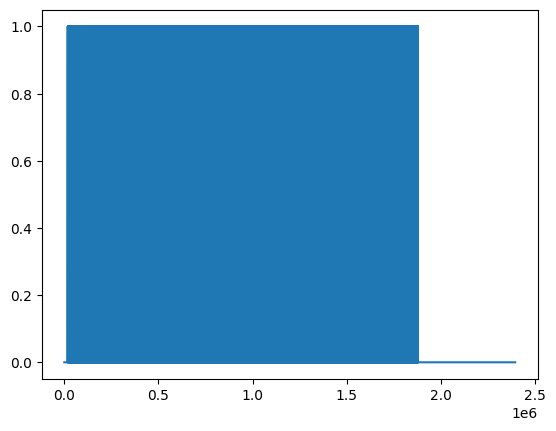

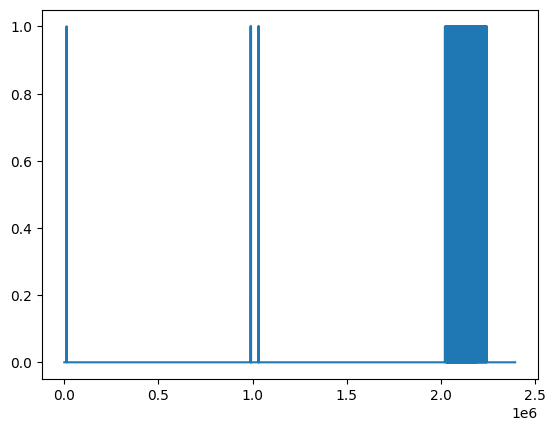

In [4]:
'''
Get the NI file which end with t0.nidq.bin if you didn't include stimulation period during spikesorting.
Otherwise, chose tcat.nidq.bin which two files (usually g0 and g1 files) are concatenated.
'''
root = Tk()         
root.withdraw()    

# Windows specific; forces the window to appear in front
root.attributes("-topmost", True)

binFullPath = Path(filedialog.askopenfilename(title="Select binary file"))
base_dir = os.path.dirname(binFullPath) ## This should be "E:\\Neuropixels\\runname_g0"
root.destroy()
print(base_dir)

# Other parameters about what data to read

tagging=True      # if you did spike sorting with tagging period--> True

'''
Which digital word to read. 
For imec, there is only 1 digital word, dw = 0.
For NI, digital lines 0-15 are in word 0,lines 16-31 are in word 1, etc.
'''
dw = 0    

'''
Which lines within the digital word, zero-based
Note that the SYNC line for PXI 3B is stored in line 6.
'''

meta = readMeta(binFullPath)
sRate = SampRate(meta)
rawData = makeMemMapRaw(binFullPath, meta)
nChan, nFileSamp = rawData.shape

dLineList = [0,7] if tagging else [0]

tStart = 0        # in seconds
firstSamp = int(sRate*tStart)

lastSamp = nFileSamp - 1

# tEnd = 1250       # this is kind of cumbersome to find the end time manually, need to ask the way to do this easier.
# lastSamp = int(sRate*tEnd)

# get digital data for the selected lines
digArray = ExtractDigital(rawData, firstSamp, lastSamp, dw, dLineList, meta)

# Plot the extracted strobe channel
tDat = np.arange(firstSamp, lastSamp+1, dtype='uint64')
tDat = 1000*tDat/sRate      # plot time axis in msec
fig, ax = plt.subplots()
ax.plot(tDat, digArray[0, :])

# Plot the extracted stimulation channels
if tagging:
    tDat = np.arange(firstSamp, lastSamp+1, dtype='uint64')
    tDat = 1000*tDat/sRate      # plot time axis in msec
    fig, ax = plt.subplots()
    ax.plot(tDat, digArray[1, :])
plt.show()


"""
1. detect the time when digital channel output changed from 0 to 1.
2. Convert the timing of NI channel into second. 
"""
if tagging:
    stimulation_times = np.where((digArray[1, :-1] == 0) & (digArray[1, 1:] == 1))[0] + 1
    stimulation_seconds = stimulation_times/sRate
    stimulation_off_times = np.where((digArray[1, :-1] == 1) & (digArray[1, 1:] == 0))[0]
    stimulation_off_seconds = stimulation_off_times/sRate
strobe_times = np.where((digArray[0, :-1] == 0) & (digArray[0, 1:] == 1))[0] + 1
strobe_seconds = strobe_times/sRate

In [3]:
data = pd.read_csv(r"D:\Neuropixels\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0\kilosort4qMetrics\templates._bc_unit_labels.tsv", sep='\t')
counts = data['unitType'].value_counts().sort_index()
for unit_type in range(4):
    print(f"{unit_type}: {counts.get(unit_type, 0)}")

data = pd.read_csv(r"D:\Neuropixels\9153_01292025_2_tagging_g0\9153_01292025_2_tagging_g0_imec0\kilosort4qMetrics\templates._bc_unit_labels.tsv", sep='\t')
counts = data['unitType'].value_counts().sort_index()
for unit_type in range(4):
    print(f"{unit_type}: {counts.get(unit_type, 0)}")

0: 142
1: 96
2: 289
3: 81
0: 156
1: 108
2: 293
3: 75


In [6]:
offset = 18

print(stimulation_seconds[offset:120+offset])
print(stimulation_seconds[120+offset:320+offset])

[2026.51848845 2028.51677035 2030.51505225 2032.51333415 2034.51161605
 2036.50999235 2038.50827425 2040.50655615 2042.50483805 2044.50311996
 2046.50140186 2048.49968376 2050.49796566 2052.49624756 2054.49452946
 2056.49281136 2058.49109326 2060.48937516 2062.48775146 2064.48603336
 2066.48431526 2068.48259716 2070.48087906 2072.47916096 2074.47744286
 2076.47572476 2078.47400666 2080.47228857 2082.47057047 2084.46885237
 2086.46713427 2088.46541617 2090.46369807 2092.46197997 2094.46026187
 2096.45863817 2098.45692007 2100.45520197 2102.45348387 2104.45176577
 2106.45004767 2108.44832957 2110.44661147 2112.44489337 2114.44317527
 2116.44145717 2118.43973908 2120.43802098 2122.43630288 2124.43458478
 2126.43296108 2128.43124298 2130.42952488 2132.42780678 2134.42608868
 2136.42437058 2138.42265248 2140.42093438 2142.41921628 2144.41749818
 2146.41578008 2148.41415638 2150.41243829 2152.41072019 2154.40900209
 2156.40728399 2158.40556589 2160.40384779 2162.40212969 2164.40041159
 2166.

In [7]:
# offset = 6
# stimulation_seconds = stimulation_seconds[:-offset]
# stimulation_times = stimulation_times[:-offset]
# stimulation_off_seconds = stimulation_off_seconds[:-offset]
# stimulation_off_times = stimulation_off_times[:-offset]

In [8]:
stimulation_seconds = stimulation_seconds[offset:]
stimulation_times = stimulation_times[offset:]
stimulation_off_seconds = stimulation_off_seconds[offset:]
stimulation_off_times = stimulation_off_times[offset:]

In [9]:
# Get neural data file
root = Tk()         
root.withdraw()

# Windows specific; forces the window to appear in front
root.attributes("-topmost", True)

binFullPath = Path(filedialog.askopenfilename(title="Select binary file"))
root.destroy()
spike_dir = os.path.dirname(binFullPath) ## This should be "E:\\Neuropixels\\runname_g0"
spike_dir

'D:\\Neuropixels\\9153_01292025_2_tagging_g0\\9153_01292025_2_tagging_g0_imec0'

In [10]:
## save the digital I/O timings as .npy files
strobe_seconds_path = os.path.join(
        spike_dir,
        "kilosort4",
        "strobe_seconds.npy"
    )
np.save(strobe_seconds_path, strobe_seconds)

strobe_times_path = os.path.join(
        spike_dir,
        "kilosort4",
        "strobe_times.npy"
    )
np.save(strobe_times_path, strobe_times)

if tagging:
    stimulation_seconds_path = os.path.join(
        spike_dir,
        "kilosort4",
        "stimulation_seconds.npy"
    )
    np.save(stimulation_seconds_path, stimulation_seconds)
    
    stimulation_times_path = os.path.join(
        spike_dir,
        "kilosort4",
        "stimulation_times.npy"
    )
    np.save(stimulation_times_path, stimulation_times)

    stimulation_off_seconds_path = os.path.join(
        spike_dir,
        "kilosort4",
        "stimulation_off_seconds.npy"
    )
    np.save(stimulation_off_seconds_path, stimulation_off_seconds)

    stimulation_off_times_path = os.path.join(
        spike_dir,
        "kilosort4",
        "stimulation_off_times.npy"
    )
    np.save(stimulation_off_times_path, stimulation_off_times)

In [11]:
# save the spike timings as .npy files.
if tagging:
    kilosort_dir = "kilosort4"
else:
    kilosort_dir = "kilosort4_wotag"

meta = readMeta(binFullPath)
sRate = SampRate(meta)

## Load "spike_time.npy"
spiketime_path = os.path.join(
        spike_dir,
        "kilosort4",
        "spike_times.npy"
    )
spike_seconds = np.load(spiketime_path)/sRate # convert the spike timing into seconds.

## save the absolute time of the spikes
spike_seconds_path = os.path.join(
        spike_dir,
        "kilosort4",
        "spike_seconds.npy"
    )
np.save(spike_seconds_path, spike_seconds)

Finally, map imec stream to NI stream.  
On command line, go the /TPrime-win directory then execute below.  
> TPrime -syncperiod=1.0 -tostream=path_to_the_edge_data_of_the_NI_flow -fromstream=1,path_to_the_edge_data_of_the_imec_probe -events=1,path_to_the_spike_seconds.npy,path_to_save_spike_seconds_adj.npy

Now, I got a **spike_seconds_adj.npy** file in the /sorter_output folder

In [12]:
## Eliminate the spike times close to stimulation edge.

## Load the adjusted absolute time of the spikes
spikes = np.load(spike_dir+'/kilosort4/spike_seconds_adj.npy')
stim_times = np.concatenate((stimulation_seconds, stimulation_off_seconds))      # shape (N_events,)
tol = 0.001  # = 1 ms

mask = np.ones(len(spikes), dtype=bool)

for t in stim_times:
    # keep only those spikes whose distance from t is > tol
    mask &= np.abs(spikes - t) > tol

mask_path = os.path.join(
        spike_dir,
        "kilosort4",
        "spike_mask.npy"
    )
np.save(mask_path, mask)

### Opto-tagging

Finally, I will align spike data with stimulation timing and look how.  
Bombcell's spike_label contains the int64 array that each element represent the following annotation:

0. Noise
1. Good
2. MUA
3. non-Somatic

For opto-tagging protocol:  
see [Allen institute Open Scope](https://alleninstitute.github.io/openscope_databook/first-order/optotagging.html)  
also see [Johannes W. de Jong et al., Nat. Neorosci. 2024](https://www.nature.com/articles/s41593-023-01547-6)  

Currently, I'm trying out various type of stimulation.  
5 or 10 ms stimulation sometimes work, however, most of the time, it just mess up the signal during stimulation. So, I think 1 ms stim or 2 ms stim combined with antidromic tagging is more promising.  

Current protocol is following:  
* 1ms square pulse (20 times) interleaved with 3sec.
* 2ms square pulse (20 times) interleaved with 3sec.
* 5ms square pulse (20 times) interleaved with 3sec.
* 10ms square pulse (20 times) interleaved with 3sec.
* 1sec of 10Hz stim with 2ms square pulse (10 cycles) interleaved with 5sec. 

Save the PSTH dictionary as "**good_unit_psth.npy**"   
psth_data[ unit# ][ 'raster' or 'hist' ]

In [13]:
from scipy.ndimage import gaussian_filter1d

def make_raster_and_psth(spike_times, events, window, bins, sigma_bins=3):
    """
    Returns:
      rasters: list of 1D arrays (spike_times_rel) per trial
      psth:    smoothed firing rate (Hz) at each bin center
      bin_centers: 1D array of bin centers
    """
    rasters = []
    all_spikes = []

    for t0 in events:
        # relative spike times for this trial
        rel = spike_times - t0
        mask = (rel >= window[0]) & (rel <= window[1])
        rel_sp = rel[mask]
        rasters.append(rel_sp)
        all_spikes.append(rel_sp)

    # flatten for histogram
    all_spikes = np.hstack(all_spikes)
    counts, edges = np.histogram(all_spikes, bins=bins)
    # calculate bin width (assume uniform bins)
    bin_width = np.diff(bins)[0]
    # convert to rate: counts/(n_trials*bin_width)
    rate = counts / (len(events) * bin_width)
    # smooth
    rate_smooth = gaussian_filter1d(rate, sigma_bins)
    # bin centers
    centers = edges[:-1] + np.diff(edges)/2
    return rasters, rate_smooth, centers

In [ ]:
"""Direct tagging method"""

tagging = True

core_dir = r"D:/Neuropixels"
date_strs = [
    '01292025_2'
]

# build session names and corresponding spike_dir paths
session_names = [f"9153_{d}_tagging_g0" for d in date_strs]
spike_dirs = [
    os.path.join(core_dir, sess, f"{sess}_imec0")
    for sess in session_names
]

# Display the list of spike_dir paths
for spike_dir in spike_dirs:
    # Load the data
    if tagging:
        spike_mask = np.load(spike_dir+'/kilosort4/spike_mask.npy')
        stimulation_seconds = np.load(spike_dir+'/kilosort4/stimulation_seconds.npy')
        spike_seconds_adj = np.load(spike_dir+'/kilosort4/spike_seconds_adj.npy')[spike_mask]
        spike_clusters = np.load(spike_dir+'/kilosort4/spike_clusters.npy')[spike_mask]
        spike_label = pd.read_csv(spike_dir+'/kilosort4qMetrics/templates._bc_unit_labels.tsv', sep='\t')
        good_units = spike_label[spike_label["unitType"] == 1].index
        mua_units = spike_label[spike_label["unitType"] == 2].index
    else:
        spike_seconds_adj = np.load(spike_dir+'/kilosort4_wotag/spike_seconds_adj.npy')
        spike_clusters = np.load(spike_dir+'/kilosort4_wotag/spike_clusters.npy')
        spike_label = pd.read_csv(spike_dir+'/kilosort4_wotagqMetrics/templates._bc_unit_labels.tsv', sep='\t')
        good_units = spike_label[spike_label["unitType"] == 1].index
        mua_units = spike_label[spike_label["unitType"] == 2].index
    print('Good unit #: ',len(good_units))
    print('Good unit list: ', good_units)
    print('MUA unit #: ',len(mua_units))
    print('MUA unit list: ', mua_units)

    psth_dir = os.path.join(spike_dir, 'PSTHs')
    os.makedirs(psth_dir, exist_ok=True)
    
    ### define paradigms ###
    # first 80 pulses: durations [1,2,5,10] ms in blocks of 20
    on1      = stimulation_seconds[:80]
    dur_blocks = np.concatenate([
        np.full(20, 0.001),
        np.full(20, 0.002),
        np.full(20, 0.005),
        np.full(20, 0.010),
    ])
    
    # next 100 pulses → 10 trains of 10 @10 Hz; use only the 1st pulse of each train
    on2_all  = stimulation_seconds[80:180]
    trains   = on2_all.reshape(10, 10)
    on2      = trains[:, 0]
    
    ### PSTH parameters ###
    # first paradigm: window = [-20 ms, +30 ms]
    win1     = (-0.020, +0.030)
    # second paradigm: window = [-2 s, +3 s]
    win2     = (-2.0, +3.0)
    bin_width_1 = 0.001    # 1 ms bins for 1
    bin_width_2 = 0.1      # 100ms bins for 2
    bins1     = np.arange(win1[0], win1[1] + bin_width_1, bin_width_1)
    bins2     = np.arange(win2[0], win2[1] + bin_width_2, bin_width_2)
    # Gaussian smoothing sigma (in bins)
    sigma_bins = 3
    
    render = True
    
    tagged_good_units = []
    # Generate PSTH raster and histograms for each good unit
    for unit in good_units:
        spikes = spike_seconds_adj[spike_clusters == unit]

        # 1) compute PSTH for plotting (–20…+30 ms)
        ras1, psth1, ctr1 = make_raster_and_psth(spikes, on1, win1, bins1)
        ras2, psth2, ctr2 = make_raster_and_psth(spikes, on2, win2, bins2)
    
        # 2) compute PSTH over a wider baseline window (–1…+1 s)
        win_base   = (-1.0, +1.0)
        bins_base  = np.arange(win_base[0], win_base[1] + bin_width_1, bin_width_1)
        _, base_rate, _ = make_raster_and_psth(spikes, on1, win_base, bins_base)
        baseline_mu   = base_rate.mean()
        baseline_sigma= base_rate.std(ddof=1)
    
        # 3) extract response peak in 2…10 ms from your original PSTH
        resp_idx = np.where((ctr1>=0.002)&(ctr1<=0.010))[0]
        resp_peak = psth1[resp_idx].max()

        # 4) count total spikes from 0 to 10 ms across all 80 trials
        #    vectorized: (n_spikes × n_trials) boolean matrix
        rel_mat        = spikes[:, None] - on1[None, :]   # shape (n_spikes, 80)
        in_window_mat  = (rel_mat >= 0) & (rel_mat <= 0.010)
        n_spikes_0_10  = int(in_window_mat.sum())
    
        # 5) z‐score decision
        zscore    = (resp_peak - baseline_mu) / baseline_sigma
        is_tagged = (zscore > 3) and (n_spikes_0_10 > 10)
        if is_tagged:
            tagged_good_units.append(unit)
        print(f"Unit {unit}: n_spikes={n_spikes_0_10} z={zscore:.2f}  → tagged? {is_tagged}")
        
        # plotting ────────────────────────────────────────────────────────────
        if render:
            fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,10))

            # ––––– Paradigm 1 raster & PSTH –––––
            # highlight all trials 1–80 in yellow
            ax1.axvspan(0, 2, color='yellow', alpha=0.1)
        
            for i, trial in enumerate(ras1):
                ax1.vlines(trial*1e3, i+0.5, i+1.5, color='k')
            ax1.set_xlim(win1[0]*1e3, win1[1]*1e3)
            ax1.set_ylim(0.5, len(on1)+0.5)
            ax1.set_ylabel('Trial')
            ax1.set_title(f'Paradigm 1 (–20 ms to +30 ms) – {"TAGGED" if is_tagged else "not"}')
        
            ax1b = ax1.twinx()
            ax1b.plot(ctr1*1e3, psth1, color='r')
            ax1b.set_ylabel('Rate (Hz)')
        
            # ––––– Paradigm 2 raster & PSTH –––––
            ax2.axvspan(0, 1, color='yellow', alpha=0.1)  # optional
            for i, trial in enumerate(ras2):
                ax2.vlines(trial, i+0.5, i+1.5, color='k')
            ax2.set_xlim(win2)
            ax2.set_ylim(0.5, len(on2)+0.5)
            ax2.set_ylabel('Trial')
            ax2.set_xlabel('Time (s)')
            ax2.set_title('Paradigm 2 (–2 s to +3 s)')
        
            ax2b = ax2.twinx()
            ax2b.plot(ctr2, psth2, color='r')
            ax2b.set_ylabel('Rate (Hz)')
        
            plt.tight_layout()
            plt.savefig(f"{psth_dir}/psth_unit{unit}.png", dpi=300)
            plt.close(fig)
            
    tagged_good_units = np.array(tagged_good_units)
    np.save(spike_dir+'/kilosort4/tagged_good_units.npy', tagged_good_units)
    
    tagged_mua_units = []
    # Generate PSTH raster and histograms for each good unit
    for unit in mua_units:
        spikes = spike_seconds_adj[spike_clusters == unit]

        # 1) compute PSTH for plotting (–20…+30 ms)
        ras1, psth1, ctr1 = make_raster_and_psth(spikes, on1, win1, bins1)
        ras2, psth2, ctr2 = make_raster_and_psth(spikes, on2, win2, bins2)
    
        # 2) compute PSTH over a wider baseline window (–1…+1 s)
        win_base   = (-1.0, +1.0)
        bins_base  = np.arange(win_base[0], win_base[1] + bin_width_1, bin_width_1)
        _, base_rate, _ = make_raster_and_psth(spikes, on1, win_base, bins_base)
        baseline_mu   = base_rate.mean()
        baseline_sigma= base_rate.std(ddof=1)
    
        # 3) extract response peak in 2…10 ms from your original PSTH
        resp_idx = np.where((ctr1>=0.002)&(ctr1<=0.010))[0]
        resp_peak = psth1[resp_idx].max()

        # 4) count total spikes from 0 to 10 ms across all 80 trials
        #    vectorized: (n_spikes × n_trials) boolean matrix
        rel_mat        = spikes[:, None] - on1[None, :]   # shape (n_spikes, 80)
        in_window_mat  = (rel_mat >= 0) & (rel_mat <= 0.010)
        n_spikes_0_10  = int(in_window_mat.sum())
    
        # 5) z‐score decision
        zscore    = (resp_peak - baseline_mu) / baseline_sigma
        is_tagged = (zscore > 3) and (n_spikes_0_10 > 10)
        if is_tagged:
            tagged_mua_units.append(unit)
        print(f"Unit {unit}: n_spikes={n_spikes_0_10} z={zscore:.2f}  → tagged? {is_tagged}")
        
        # plotting ────────────────────────────────────────────────────────────
        if render:
            fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,10))

            # ––––– Paradigm 1 raster & PSTH –––––
            # highlight all trials 1–80 in yellow
            ax1.axvspan(0, 2, color='yellow', alpha=0.1)
        
            for i, trial in enumerate(ras1):
                ax1.vlines(trial*1e3, i+0.5, i+1.5, color='k')
            ax1.set_xlim(win1[0]*1e3, win1[1]*1e3)
            ax1.set_ylim(0.5, len(on1)+0.5)
            ax1.set_ylabel('Trial')
            ax1.set_title(f'Paradigm 1 (–20 ms to +30 ms) – {"TAGGED" if is_tagged else "not"}')
        
            ax1b = ax1.twinx()
            ax1b.plot(ctr1*1e3, psth1, color='r')
            ax1b.set_ylabel('Rate (Hz)')
        
            # ––––– Paradigm 2 raster & PSTH –––––
            ax2.axvspan(0, 1, color='yellow', alpha=0.1)  # optional
            for i, trial in enumerate(ras2):
                ax2.vlines(trial, i+0.5, i+1.5, color='k')
            ax2.set_xlim(win2)
            ax2.set_ylim(0.5, len(on2)+0.5)
            ax2.set_ylabel('Trial')
            ax2.set_xlabel('Time (s)')
            ax2.set_title('Paradigm 2 (–2 s to +3 s)')
        
            ax2b = ax2.twinx()
            ax2b.plot(ctr2, psth2, color='r')
            ax2b.set_ylabel('Rate (Hz)')
        
            plt.tight_layout()
            plt.savefig(f"{psth_dir}/psth_unit{unit}.png", dpi=300)
            plt.close(fig)
    
    tagged_mua_units = np.array(tagged_mua_units)
    np.save(spike_dir+'/kilosort4/tagged_mua_units.npy', tagged_mua_units)

Good unit #:  108
Good unit list:  Index([  1,   8,  10,  15,  18,  19,  20,  32,  34,  35,
       ...
       585, 589, 593, 596, 607, 614, 620, 622, 624, 630],
      dtype='int64', length=108)
MUA unit #:  293
MUA unit list:  Index([  4,   6,  14,  17,  21,  22,  23,  27,  28,  33,
       ...
       616, 617, 618, 619, 621, 625, 627, 628, 629, 631],
      dtype='int64', length=293)
Unit 1: n_spikes=0 z=-0.28  → tagged? False
Unit 8: n_spikes=0 z=-2.47  → tagged? False
Unit 10: n_spikes=0 z=-4.64  → tagged? False
Unit 15: n_spikes=0 z=-1.33  → tagged? False
Unit 18: n_spikes=0 z=-0.35  → tagged? False
Unit 19: n_spikes=0 z=-0.30  → tagged? False
Unit 20: n_spikes=0 z=-0.60  → tagged? False
Unit 32: n_spikes=0 z=-1.04  → tagged? False
Unit 34: n_spikes=4 z=0.65  → tagged? False
Unit 35: n_spikes=1 z=1.91  → tagged? False
Unit 52: n_spikes=1 z=-1.42  → tagged? False
Unit 53: n_spikes=0 z=-0.45  → tagged? False


C:\Users\kouhi\AppData\Local\Temp\ipykernel_15928\2309379975.py:98: RuntimeWarning: invalid value encountered in scalar divide
  zscore    = (resp_peak - baseline_mu) / baseline_sigma


Unit 64: n_spikes=0 z=nan  → tagged? False
Unit 71: n_spikes=0 z=-0.17  → tagged? False
Unit 76: n_spikes=0 z=4.51  → tagged? False
Unit 81: n_spikes=45 z=9.34  → tagged? True
Unit 84: n_spikes=0 z=-3.83  → tagged? False
Unit 94: n_spikes=6 z=6.72  → tagged? False
Unit 107: n_spikes=1 z=5.76  → tagged? False
Unit 108: n_spikes=46 z=14.35  → tagged? True
Unit 114: n_spikes=3 z=-1.12  → tagged? False
Unit 117: n_spikes=1 z=5.19  → tagged? False
Unit 123: n_spikes=0 z=-1.64  → tagged? False
Unit 127: n_spikes=1 z=3.64  → tagged? False
Unit 130: n_spikes=0 z=-0.59  → tagged? False
Unit 133: n_spikes=0 z=-2.06  → tagged? False
Unit 137: n_spikes=0 z=-0.65  → tagged? False
Unit 161: n_spikes=0 z=-4.52  → tagged? False
Unit 166: n_spikes=0 z=-0.81  → tagged? False
Unit 175: n_spikes=0 z=-0.70  → tagged? False
Unit 187: n_spikes=0 z=-2.27  → tagged? False
Unit 195: n_spikes=3 z=9.74  → tagged? False
Unit 200: n_spikes=0 z=-2.13  → tagged? False
Unit 212: n_spikes=0 z=-1.56  → tagged? False
Uni

C:\Users\kouhi\AppData\Local\Temp\ipykernel_15928\2309379975.py:171: RuntimeWarning: invalid value encountered in scalar divide
  zscore    = (resp_peak - baseline_mu) / baseline_sigma


Unit 23: n_spikes=0 z=nan  → tagged? False
Unit 27: n_spikes=0 z=nan  → tagged? False
Unit 28: n_spikes=2 z=1.67  → tagged? False
Unit 33: n_spikes=2 z=1.35  → tagged? False
Unit 36: n_spikes=18 z=6.45  → tagged? True
Unit 37: n_spikes=30 z=7.43  → tagged? True
Unit 38: n_spikes=0 z=-0.11  → tagged? False
Unit 39: n_spikes=1 z=0.29  → tagged? False
Unit 42: n_spikes=15 z=7.70  → tagged? True
Unit 43: n_spikes=0 z=-0.13  → tagged? False
Unit 44: n_spikes=7 z=7.67  → tagged? False
Unit 45: n_spikes=107 z=11.30  → tagged? True
Unit 46: n_spikes=0 z=-0.11  → tagged? False
Unit 47: n_spikes=3 z=1.08  → tagged? False
Unit 48: n_spikes=0 z=0.41  → tagged? False
Unit 49: n_spikes=0 z=nan  → tagged? False
Unit 50: n_spikes=3 z=0.61  → tagged? False
Unit 58: n_spikes=0 z=nan  → tagged? False
Unit 60: n_spikes=0 z=0.16  → tagged? False
Unit 63: n_spikes=0 z=nan  → tagged? False
Unit 65: n_spikes=0 z=-0.48  → tagged? False
Unit 66: n_spikes=0 z=nan  → tagged? False
Unit 67: n_spikes=0 z=-0.20  → t

In [14]:
"""Anti dromic tagging method"""
tagging = True

core_dir = r"D:/Neuropixels"
date_strs = [
    '06162025'
]

# build session names and corresponding spike_dir paths
session_names = [f"9303_{d}_tagging_g0" for d in date_strs]
spike_dirs = [
    os.path.join(core_dir, sess, f"{sess}_imec0")
    for sess in session_names
]

# Display the list of spike_dir paths
for spike_dir in spike_dirs:
    # Load the data
    if tagging:
        spike_mask = np.load(spike_dir+'/kilosort4/spike_mask.npy')
        stimulation_seconds = np.load(spike_dir+'/kilosort4/stimulation_seconds.npy')
        spike_seconds_adj = np.load(spike_dir+'/kilosort4/spike_seconds_adj.npy')[spike_mask]
        spike_clusters = np.load(spike_dir+'/kilosort4/spike_clusters.npy')[spike_mask]
        spike_label = pd.read_csv(spike_dir+'/kilosort4qMetrics/templates._bc_unit_labels.tsv', sep='\t')
        good_units = spike_label[spike_label["unitType"] == 1].index
        mua_units = spike_label[spike_label["unitType"] == 2].index
    else:
        spike_seconds_adj = np.load(spike_dir+'/kilosort4_wotag/spike_seconds_adj.npy')
        spike_clusters = np.load(spike_dir+'/kilosort4_wotag/spike_clusters.npy')
        spike_label = pd.read_csv(spike_dir+'/kilosort4_wotagqMetrics/templates._bc_unit_labels.tsv', sep='\t')
        good_units = spike_label[spike_label["unitType"] == 1].index
        mua_units = spike_label[spike_label["unitType"] == 2].index
    print('Good unit #: ',len(good_units))
    print('Good unit list: ', good_units)
    print('MUA unit #: ',len(mua_units))
    print('MUA unit list: ', mua_units)

    psth_dir = os.path.join(spike_dir, 'PSTHs')
    os.makedirs(psth_dir, exist_ok=True)
    
    ### define paradigms ###
    # first 80 pulses: durations [1,2,5,10] ms in blocks of 20
    on1      = stimulation_seconds[:120]
    dur_blocks = np.concatenate([
        np.full(30, 0.001),
        np.full(30, 0.002),
        np.full(30, 0.005),
        np.full(30, 0.010),
    ])
    
    # next 200 pulses → 20 trains of 10 @10 Hz; use only the 1st pulse of each train
    on2_all  = stimulation_seconds[120:320]
    trains   = on2_all.reshape(20, 10)
    on2      = trains[:, 0]
    
    ### PSTH parameters ###
    # first paradigm: window = [-20 ms, +40 ms]
    win1     = (-0.020, +0.040)
    # second paradigm: window = [-2 s, +3 s]
    win2     = (-2.0, +3.0)
    bin_width_1 = 0.001    # 1 ms bins for 1
    bin_width_2 = 0.1      # 100ms bins for 2
    bins1     = np.arange(win1[0], win1[1] + bin_width_1, bin_width_1)
    bins2     = np.arange(win2[0], win2[1] + bin_width_2, bin_width_2)
    # Gaussian smoothing sigma (in bins)
    sigma_bins = 3
    
    render = True
    
    tagged_good_units = []
    # Generate PSTH raster and histograms for each good unit
    for unit in good_units:
        spikes = spike_seconds_adj[spike_clusters == unit]

        # 1) compute PSTH for plotting (–20…+30 ms)
        ras1, psth1, ctr1 = make_raster_and_psth(spikes, on1, win1, bins1)
        ras2, psth2, ctr2 = make_raster_and_psth(spikes, on2, win2, bins2)
    
        # 2) compute PSTH over a wider baseline window (–1…+1 s)
        win_base   = (-1.0, +1.0)
        bins_base  = np.arange(win_base[0], win_base[1] + bin_width_1, bin_width_1)
        _, base_rate, _ = make_raster_and_psth(spikes, on1, win_base, bins_base)
        baseline_mu   = base_rate.mean()
        baseline_sigma= base_rate.std(ddof=1)
    
        # 3) extract response peak in 5…20 ms from your original PSTH
        resp_idx = np.where((ctr1>=0.005)&(ctr1<=0.020))[0]
        resp_peak = psth1[resp_idx].max()

        # 4) count total spikes from 0 to 10 ms across all 80 trials
        #    vectorized: (n_spikes × n_trials) boolean matrix
        rel_mat        = spikes[:, None] - on1[None, :]   # shape (n_spikes, 80)
        in_window_mat  = (rel_mat >= 0) & (rel_mat <= 0.020)
        n_spikes_0_10  = int(in_window_mat.sum())
    
        # 5) z‐score decision
        zscore    = (resp_peak - baseline_mu) / baseline_sigma
        is_tagged = (zscore > 3) and (n_spikes_0_10 > 10)
        if is_tagged:
            tagged_good_units.append(unit)
        print(f"Unit {unit}: n_spikes={n_spikes_0_10} z={zscore:.2f}  → tagged? {is_tagged}")
        
        # plotting ────────────────────────────────────────────────────────────
        if render:
            fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,10))

            # ––––– Paradigm 1 raster & PSTH –––––
            # highlight all trials 1–80 in yellow
            ax1.axvspan(0, 2, color='yellow', alpha=0.1)
        
            for i, trial in enumerate(ras1):
                ax1.vlines(trial*1e3, i+0.5, i+1.5, color='k')
            ax1.set_xlim(win1[0]*1e3, win1[1]*1e3)
            ax1.set_ylim(0.5, len(on1)+0.5)
            ax1.set_ylabel('Trial')
            ax1.set_title(f'Paradigm 1 (–20 ms to +40 ms) – {"TAGGED" if is_tagged else "not"}')
        
            ax1b = ax1.twinx()
            ax1b.plot(ctr1*1e3, psth1, color='r')
            ax1b.set_ylabel('Rate (Hz)')
        
            # ––––– Paradigm 2 raster & PSTH –––––
            ax2.axvspan(0, 1, color='yellow', alpha=0.1)  # optional
            for i, trial in enumerate(ras2):
                ax2.vlines(trial, i+0.5, i+1.5, color='k')
            ax2.set_xlim(win2)
            ax2.set_ylim(0.5, len(on2)+0.5)
            ax2.set_ylabel('Trial')
            ax2.set_xlabel('Time (s)')
            ax2.set_title('Paradigm 2 (–2 s to +3 s)')
        
            ax2b = ax2.twinx()
            ax2b.plot(ctr2, psth2, color='r')
            ax2b.set_ylabel('Rate (Hz)')
        
            plt.tight_layout()
            plt.savefig(f"{psth_dir}/psth_unit{unit}.png", dpi=300)
            plt.close(fig)
            
    tagged_good_units = np.array(tagged_good_units)
    np.save(spike_dir+'/kilosort4/tagged_good_units.npy', tagged_good_units)
    
    tagged_mua_units = []
    # Generate PSTH raster and histograms for each good unit
    for unit in mua_units:
        spikes = spike_seconds_adj[spike_clusters == unit]

        # 1) compute PSTH for plotting (–20…+40 ms)
        ras1, psth1, ctr1 = make_raster_and_psth(spikes, on1, win1, bins1)
        ras2, psth2, ctr2 = make_raster_and_psth(spikes, on2, win2, bins2)
    
        # 2) compute PSTH over a wider baseline window (–1…+1 s)
        win_base   = (-1.0, +1.0)
        bins_base  = np.arange(win_base[0], win_base[1] + bin_width_1, bin_width_1)
        _, base_rate, _ = make_raster_and_psth(spikes, on1, win_base, bins_base)
        baseline_mu   = base_rate.mean()
        baseline_sigma= base_rate.std(ddof=1)
    
        # 3) extract response peak in 5…20 ms from your original PSTH
        resp_idx = np.where((ctr1>=0.005)&(ctr1<=0.020))[0]
        resp_peak = psth1[resp_idx].max()

        # 4) count total spikes from 0 to 10 ms across all 80 trials
        #    vectorized: (n_spikes × n_trials) boolean matrix
        rel_mat        = spikes[:, None] - on1[None, :]   # shape (n_spikes, 80)
        in_window_mat  = (rel_mat >= 0) & (rel_mat <= 0.020)
        n_spikes_0_10  = int(in_window_mat.sum())
    
        # 5) z‐score decision
        zscore    = (resp_peak - baseline_mu) / baseline_sigma
        is_tagged = (zscore > 3) and (n_spikes_0_10 > 10)
        if is_tagged:
            tagged_mua_units.append(unit)
        print(f"Unit {unit}: n_spikes={n_spikes_0_10} z={zscore:.2f}  → tagged? {is_tagged}")
        
        # plotting ────────────────────────────────────────────────────────────
        if render:
            fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,10))

            # ––––– Paradigm 1 raster & PSTH –––––
            # highlight all trials 1–80 in yellow
            ax1.axvspan(0, 2, color='yellow', alpha=0.1)
        
            for i, trial in enumerate(ras1):
                ax1.vlines(trial*1e3, i+0.5, i+1.5, color='k')
            ax1.set_xlim(win1[0]*1e3, win1[1]*1e3)
            ax1.set_ylim(0.5, len(on1)+0.5)
            ax1.set_ylabel('Trial')
            ax1.set_title(f'Paradigm 1 (–20 ms to +40 ms) – {"TAGGED" if is_tagged else "not"}')
            ax1b = ax1.twinx()
            ax1b.plot(ctr1*1e3, psth1, color='r')
            ax1b.set_ylabel('Rate (Hz)')
        
            # ––––– Paradigm 2 raster & PSTH –––––
            ax2.axvspan(0, 1, color='yellow', alpha=0.1)  # optional
            for i, trial in enumerate(ras2):
                ax2.vlines(trial, i+0.5, i+1.5, color='k')
            ax2.set_xlim(win2)
            ax2.set_ylim(0.5, len(on2)+0.5)
            ax2.set_ylabel('Trial')
            ax2.set_xlabel('Time (s)')
            ax2.set_title('Paradigm 2 (–2 s to +3 s)')
        
            ax2b = ax2.twinx()
            ax2b.plot(ctr2, psth2, color='r')
            ax2b.set_ylabel('Rate (Hz)')
        
            plt.tight_layout()
            plt.savefig(f"{psth_dir}/psth_unit{unit}.png", dpi=300)
            plt.close(fig)
    
    tagged_mua_units = np.array(tagged_mua_units)
    np.save(spike_dir+'/kilosort4/tagged_mua_units.npy', tagged_mua_units)

Good unit #:  60
Good unit list:  Index([  6,  12,  13,  15,  20,  37,  43,  56,  59,  60,  62,  64,  79,  81,
        85,  86,  92,  95, 107, 108, 110, 114, 126, 130, 144, 156, 157, 164,
       167, 169, 171, 172, 173, 183, 186, 190, 191, 193, 194, 200, 202, 203,
       205, 206, 207, 209, 210, 214, 215, 219, 230, 244, 251, 257, 258, 268,
       272, 279, 283, 309],
      dtype='int64')
MUA unit #:  177
MUA unit list:  Index([  0,   1,   2,   3,   5,   8,  10,  11,  14,  16,
       ...
       303, 304, 305, 306, 312, 313, 314, 315, 318, 320],
      dtype='int64', length=177)
Unit 6: n_spikes=11 z=0.28  → tagged? False
Unit 12: n_spikes=0 z=-0.37  → tagged? False
Unit 13: n_spikes=12 z=1.06  → tagged? False
Unit 15: n_spikes=72 z=1.13  → tagged? False
Unit 20: n_spikes=9 z=1.12  → tagged? False
Unit 37: n_spikes=5 z=-1.34  → tagged? False
Unit 43: n_spikes=54 z=1.74  → tagged? False
Unit 56: n_spikes=0 z=-0.58  → tagged? False
Unit 59: n_spikes=0 z=-0.54  → tagged? False
Unit 60: n_spi

C:\Users\kouhi\AppData\Local\Temp\ipykernel_1936\1622795337.py:170: RuntimeWarning: invalid value encountered in scalar divide
  zscore    = (resp_peak - baseline_mu) / baseline_sigma


Unit 31: n_spikes=0 z=nan  → tagged? False
Unit 32: n_spikes=42 z=0.92  → tagged? False
Unit 33: n_spikes=4 z=0.20  → tagged? False
Unit 34: n_spikes=11 z=1.73  → tagged? False
Unit 35: n_spikes=0 z=nan  → tagged? False
Unit 39: n_spikes=4 z=0.59  → tagged? False
Unit 41: n_spikes=0 z=nan  → tagged? False
Unit 42: n_spikes=0 z=-0.45  → tagged? False
Unit 45: n_spikes=45 z=1.44  → tagged? False
Unit 46: n_spikes=1 z=2.89  → tagged? False
Unit 47: n_spikes=6 z=1.10  → tagged? False
Unit 49: n_spikes=7 z=1.92  → tagged? False
Unit 50: n_spikes=0 z=-0.07  → tagged? False
Unit 52: n_spikes=9 z=2.49  → tagged? False
Unit 53: n_spikes=8 z=2.61  → tagged? False
Unit 54: n_spikes=3 z=0.96  → tagged? False
Unit 57: n_spikes=2 z=1.65  → tagged? False
Unit 58: n_spikes=6 z=2.34  → tagged? False
Unit 63: n_spikes=0 z=-0.53  → tagged? False
Unit 66: n_spikes=0 z=-0.71  → tagged? False
Unit 67: n_spikes=28 z=2.03  → tagged? False
Unit 68: n_spikes=4 z=0.92  → tagged? False
Unit 69: n_spikes=2 z=0.17 

In [ ]:
# ### Save good and mua unit PSTHs

# tagging = True
# render = False

# core_dir = r"D:/Neuropixels"
# date_strs = [
#     '01282025','01292025','01302025','01312025',
#     '02012025','02022025','02032025','02042025',
#     '02062025','02072025','02092025','02102025',
#     '02112025','02122025','02132025','02142025',
#     '02152025','02162025'
# ]
# # build session names and corresponding spike_dir paths
# session_names = [f"9153_{d}_tagging_g0" for d in date_strs]
# spike_dirs = [
#     os.path.join(core_dir, sess, f"{sess}_imec0")
#     for sess in session_names
# ]

# # Display the list of spike_dir paths
# for spike_dir in spike_dirs:
#     # Load the data
#     if tagging:
#         spike_mask = np.load(spike_dir+'/kilosort4/spike_mask.npy')
#         stimulation_seconds = np.load(spike_dir+'/kilosort4/stimulation_seconds.npy')
#         spike_seconds_adj = np.load(spike_dir+'/kilosort4/spike_seconds_adj.npy')[spike_mask]
#         spike_clusters = np.load(spike_dir+'/kilosort4/spike_clusters.npy')[spike_mask]
#         spike_label = pd.read_csv(spike_dir+'/kilosort4qMetrics/templates._bc_unit_labels.tsv', sep='\t')
#         good_units = spike_label[spike_label["unitType"] == 1].index
#         mua_units = spike_label[spike_label["unitType"] == 2].index
#     else:
#         spike_seconds_adj = np.load(spike_dir+'/kilosort4_wotag/spike_seconds_adj.npy')
#         spike_clusters = np.load(spike_dir+'/kilosort4_wotag/spike_clusters.npy')
#         spike_label = pd.read_csv(spike_dir+'/kilosort4_wotagqMetrics/templates._bc_unit_labels.tsv', sep='\t')
#         good_units = spike_label[spike_label["unitType"] == 1].index
#         mua_units = spike_label[spike_label["unitType"] == 2].index
#     print('Good unit #: ',len(good_units))
#     print('Good unit list: ', good_units)
#     print('MUA unit #: ',len(mua_units))
#     print('MUA unit list: ', mua_units)# Initialize storage for PSTH data for good unit
#     psth_data_good = {}

#     # Stimulation timing
#     stimulation_seconds_for10hz = stimulation_seconds[np.arange(80,180,10)]
#     stimulation_seconds = np.concatenate(
#         [stimulation_seconds[:80],
#          stimulation_seconds[np.arange(80,180,10)]
#         ]
#     )
    
#     # Time window around stimulation
#     pre_stim = -0.015  # 15 ms before stimulation
#     post_stim = 0.025  # 25 ms after stimulation
#     bin_size = 0.001  # 1 ms bins
    
#     # Time window around stimulation
#     pre_stim_for10hz = -1  # 1s before stimulation
#     post_stim_for10hz = 3  # 3s after stimulation
    
#     # Generate PSTH raster and histograms for each good unit
#     for unit in good_units:
#         # Select spikes from the good unit
#         unit_spike_times = spike_seconds_adj[spike_clusters == unit]
        
#         # Raster and histogram data
#         raster_data = []
#         hist_data = []
#         raster_data_for10hz = []
        
#         for stim_time in stimulation_seconds:
#             # Align spike times to the stimulation time
#             aligned_spikes = unit_spike_times - stim_time
#             spikes_in_window = aligned_spikes[(aligned_spikes >= pre_stim) & (aligned_spikes <= post_stim)]
#             raster_data.append(spikes_in_window)
#             hist_data.extend(spikes_in_window)
    
#         for stim_time in stimulation_seconds_for10hz:
#             # Align spike times to the onset of 10hz stim
#             aligned_spikes = unit_spike_times - stim_time
#             spikes_in_window = aligned_spikes[(aligned_spikes >= pre_stim_for10hz) & (aligned_spikes <= post_stim_for10hz)]
#             raster_data_for10hz.append(spikes_in_window)
        
#         # Store data for plotting
#         psth_data_good[unit] = {
#             "raster": raster_data,
#             "hist": np.histogram(hist_data, bins=np.arange(pre_stim, post_stim + bin_size, bin_size))[0],
#             "raster_10hz": raster_data_for10hz,
#         }
    
#     # Initialize storage for PSTH data for mua unit
#     psth_data_mua = {}
    
#     # Time window around stimulation
#     pre_stim = -0.015  # 15 ms before stimulation
#     post_stim = 0.025  # 25 ms after stimulation
#     bin_size = 0.001  # 1 ms bins
    
#     # Time window around stimulation
#     pre_stim_for10hz = -1  # 1s before stimulation
#     post_stim_for10hz = 3  # 3s after stimulation
    
#     # Generate PSTH raster and histograms for each good unit
#     for unit in mua_units:
#         # Select spikes from the good unit
#         unit_spike_times = spike_seconds_adj[spike_clusters == unit]
        
#         # Raster and histogram data
#         raster_data = []
#         hist_data = []
#         raster_data_for10hz = []
        
#         for stim_time in stimulation_seconds:
#             # Align spike times to the stimulation time
#             aligned_spikes = unit_spike_times - stim_time
#             spikes_in_window = aligned_spikes[(aligned_spikes >= pre_stim) & (aligned_spikes <= post_stim)]
#             raster_data.append(spikes_in_window)
#             hist_data.extend(spikes_in_window)
    
#         for stim_time in stimulation_seconds_for10hz:
#             # Align spike times to the onset of 10hz stim
#             aligned_spikes = unit_spike_times - stim_time
#             spikes_in_window = aligned_spikes[(aligned_spikes >= pre_stim_for10hz) & (aligned_spikes <= post_stim_for10hz)]
#             raster_data_for10hz.append(spikes_in_window)
        
#         # Store data for plotting
#         psth_data_mua[unit] = {
#             "raster": raster_data,
#             "hist": np.histogram(hist_data, bins=np.arange(pre_stim, post_stim + bin_size, bin_size))[0],
#             "raster_10hz": raster_data_for10hz,
#         }
    
#     Tagged_units=[]
#     # Plot results for each good unit
#     for unit, data in psth_data_good.items():
#         raster = data["raster"]
#         histogram = data["hist"]
#         raster_for10hz = data["raster_10hz"]
#         time_bins = np.arange(pre_stim, post_stim, bin_size)
    
#         ## Zero-ing the histogram around the stimulation
#         histogram[19]=0
#         histogram[20]=0
    
#         ## If only enough amount of spike are observed in the PSTH
#         if sum(histogram) > 10:
#             histogram = histogram/sum(histogram)
#             peak = [histogram[i]+histogram[i+1] for i in range(21,28)] ##1.0-3.0, 2.0-4.0, 3.0-5.0, 4.0-6.0, ,,,,,8.0-10.0 msec. 2 msec window slid by 1 msec.
#             if any(x > 0.3 for x in peak):
#                 psth_data_good[unit]['Tag'] = True
#                 Tagged_units.append(unit) 
#             else:
#                 psth_data_good[unit]['Tag'] = False
#         else:
#             psth_data_good[unit]['Tag'] = False
    
#         # Plot Raster
#         if render:
#             plt.figure(figsize=(10, 6))
#             plt.subplot(3, 1, 1)
#             for trial_index, trial_spikes in enumerate(raster):
#                 plt.vlines(trial_spikes, trial_index + 0.5, trial_index + 1.5, color='black', linewidth=2)
#             plt.axvline(0, color='red', linestyle='--', label='Stimulation Onset')
#             # Add red shading for specific y-index ranges
#             plt.axvspan(0, 0.001, ymin=0 / len(raster), ymax=19 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             plt.axvspan(0, 0.002, ymin=20 / len(raster), ymax=39 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             plt.axvspan(0, 0.005, ymin=40 / len(raster), ymax=59 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             plt.axvspan(0, 0.010, ymin=60 / len(raster), ymax=79 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             plt.axvspan(0, 0.002, ymin=80 / len(raster), ymax=90 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
            
#             plt.xlim(pre_stim, post_stim)
#             plt.ylim(0.5, len(raster) + 0.5)
#             plt.xlabel('Time (s)')
#             plt.ylabel('Trial')
#             plt.title(f'Raster Plot - Unit {unit}')
#             plt.legend()
        
#             # Plot Histogram
#             plt.subplot(3, 1, 2)
#             plt.bar(time_bins, histogram, width=bin_size, align='edge', color='blue', edgecolor='black')
#             plt.axvline(0, color='red', linestyle='--', label='Stimulation Onset')
#             plt.xlim(pre_stim, post_stim)
#             plt.xlabel('Time (s)')
#             plt.ylabel('Spike Count')
#             plt.title(f'PSTH - Unit {unit}')
#             plt.legend()
        
#             # Plot Raster for 10Hz stim
#             plt.subplot(3, 1, 3)
#             for trial_index, trial_spikes in enumerate(raster_for10hz):
#                 plt.vlines(trial_spikes, trial_index + 0.5, trial_index + 1.5, color='black', linewidth=2)
#             plt.axvline(0, color='red', linestyle='--', label='Stimulation Onset')
#             plt.axvspan(0, 1, ymin=0 / len(raster_for10hz), ymax=19 / len(raster_for10hz), facecolor='yellow', alpha=0.2, edgecolor='none')
#             plt.xlim(pre_stim_for10hz, post_stim_for10hz)
#             plt.ylim(0.5, len(raster_for10hz) + 0.5)
#             plt.xlabel('Time (s)')
#             plt.ylabel('Trial')
#             plt.title(f'Raster Plot - Unit {unit}')
#             plt.legend()
#             plt.tight_layout()
#             plt.show()
    
#     #Plot result for each mua unit
#     for unit, data in psth_data_mua.items():
#         raster = data["raster"]
#         histogram = data["hist"]
#         raster_for10hz = data["raster_10hz"]
#         time_bins = np.arange(pre_stim, post_stim, bin_size)
    
#         ## Zero-ing the histogram around the stimulation
#         histogram[19]=0
#         histogram[20]=0
    
#         ## If only enough amount of spike are observed in the PSTH
#         if sum(histogram) > 10:
#             histogram = histogram/sum(histogram)
#             peak = [histogram[i]+histogram[i+1] for i in range(21,28)] ##1.0-3.0, 2.0-4.0, 3.0-5.0, 4.0-6.0, ,,,,,8.0-10.0 msec. 2 msec window slid by 1 msec.
#             if any(x > 0.3 for x in peak):
#                 psth_data_mua[unit]['Tag'] = True
#                 Tagged_units.append(unit)
#             else:
#                 psth_data_mua[unit]['Tag'] = False
#         else:
#             psth_data_mua[unit]['Tag'] = False
    
#         # Plot Raster
#         if render:
#             plt.figure(figsize=(10, 6))
#             plt.subplot(3, 1, 1)
#             for trial_index, trial_spikes in enumerate(raster):
#                 plt.vlines(trial_spikes, trial_index + 0.5, trial_index + 1.5, color='black', linewidth=2)
#             plt.axvline(0, color='red', linestyle='--', label='Stimulation Onset')
#             # Add red shading for specific y-index ranges
#             plt.axvspan(0, 0.001, ymin=0 / len(raster), ymax=19 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             #plt.axvspan(0, 0.001, ymin=80 / len(raster), ymax=99 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
            
#             plt.axvspan(0, 0.002, ymin=20 / len(raster), ymax=39 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             plt.axvspan(0, 0.002, ymin=80 / len(raster), ymax=90 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             #plt.axvspan(0, 0.002, ymin=160 / len(raster), ymax=179 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
        
#             plt.axvspan(0, 0.005, ymin=40 / len(raster), ymax=59 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             #plt.axvspan(0, 0.005, ymin=120 / len(raster), ymax=139 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
        
#             plt.axvspan(0, 0.010, ymin=60 / len(raster), ymax=79 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
#             #plt.axvspan(0, 0.010, ymin=140 / len(raster), ymax=159 / len(raster), facecolor='yellow', alpha=0.4, edgecolor='none')
        
#             plt.xlim(pre_stim, post_stim)
#             plt.ylim(0.5, len(raster) + 0.5)
#             plt.xlabel('Time (s)')
#             plt.ylabel('Trial')
#             plt.title(f'Raster Plot - Unit {unit}')
#             plt.legend()
        
#             # Plot Histogram
#             plt.subplot(3, 1, 2)
#             plt.bar(time_bins, histogram, width=bin_size, align='edge', color='blue', edgecolor='black')
#             plt.axvline(0, color='red', linestyle='--', label='Stimulation Onset')
#             plt.xlim(pre_stim, post_stim)
#             plt.xlabel('Time (s)')

            
#             plt.ylabel('Spike Count')
#             plt.title(f'PSTH - Unit {unit}')
#             plt.legend()
        
#             # Plot Raster for 10Hz stim
#             plt.subplot(3, 1, 3)
#             for trial_index, trial_spikes in enumerate(raster_for10hz):
#                 plt.vlines(trial_spikes, trial_index + 0.5, trial_index + 1.5, color='black', linewidth=2)
#             plt.axvline(0, color='red', linestyle='--', label='Stimulation Onset')
#             plt.axvspan(0, 1, ymin=0 / len(raster_for10hz), ymax=19 / len(raster_for10hz), facecolor='yellow', alpha=0.2, edgecolor='none')
#             plt.xlim(pre_stim_for10hz, post_stim_for10hz)
#             plt.ylim(0.5, len(raster_for10hz) + 0.5)
#             plt.xlabel('Time (s)')
#             plt.ylabel('Trial')
#             plt.title(f'Raster Plot - Unit {unit}')
#             plt.legend()
        
#             plt.tight_layout()
#             plt.show()
        
#     ### Save the data    
#     np.save(spike_dir+'/kilosort4/good_unit_psth.npy', psth_data_good)
#     np.save(spike_dir+'/kilosort4/mua_unit_psth.npy', psth_data_mua)

Good unit #:  144
Good unit list:  Index([  2,  10,  12,  16,  20,  28,  31,  40,  43,  44,
       ...
       489, 492, 493, 494, 495, 497, 508, 515, 516, 517],
      dtype='int64', length=144)
MUA unit #:  259
MUA unit list:  Index([  0,   1,   3,   4,   5,   6,  13,  14,  15,  17,
       ...
       503, 504, 506, 507, 509, 511, 512, 518, 520, 521],
      dtype='int64', length=259)
Good unit #:  132
Good unit list:  Index([  0,   1,  12,  19,  22,  35,  36,  65,  67,  77,
       ...
       824, 826, 833, 835, 837, 841, 842, 843, 848, 852],
      dtype='int64', length=132)
MUA unit #:  239
MUA unit list:  Index([  2,   4,   5,   6,   7,  24,  28,  34,  39,  40,
       ...
       825, 827, 828, 836, 838, 839, 845, 847, 851, 854],
      dtype='int64', length=239)
Good unit #:  107
Good unit list:  Index([ 14,  18,  19,  26,  31,  35,  39,  41,  42,  44,
       ...
       312, 319, 321, 322, 325, 327, 329, 332, 336, 342],
      dtype='int64', length=107)
MUA unit #:  98
MUA unit list:  In

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

core_dir = r"D:/Neuropixels"
date_strs = [
    '01292025_2'
]
session_names = [f"9153_{d}_tagging_g0" for d in date_strs]

all_tagged_xy = []
all_non_xy    = []

for session in session_names:
    ks_dir = os.path.join(core_dir, session, f"{session}_imec0", "kilosort4")
    # paths
    pos_path      = os.path.join(ks_dir, 'spike_positions.npy')
    clusters_path = os.path.join(ks_dir, 'spike_clusters.npy')
    tagged_good_p = os.path.join(ks_dir, 'tagged_good_units.npy')
    tagged_mua_p  = os.path.join(ks_dir, 'tagged_mua_units.npy')
    spike_mask_p    = os.path.join(ks_dir, 'spike_mask.npy')
    # load
    spike_mask = np.load(spike_mask_p)
    spikes_xy     = np.load(pos_path)[spike_mask]       # (n_spikes, ≥2)
    clusters      = np.load(clusters_path)[spike_mask]  # (n_spikes,)
    tg_good       = np.load(tagged_good_p)
    tg_mua        = np.load(tagged_mua_p)
    tagged_ids    = np.unique(np.concatenate([tg_good, tg_mua]))
    all_ids       = np.unique(clusters)
    non_tagged    = np.setdiff1d(all_ids, tagged_ids)
    # collect medians
    for u in tagged_ids:
        pts = spikes_xy[clusters==u, :2]
        if pts.size:
            all_tagged_xy.append(np.median(pts, axis=0))
    for u in non_tagged:
        pts = spikes_xy[clusters==u, :2]
        
        if pts.size:
            all_non_xy.append(np.median(pts, axis=0))
    print(session)
    print(len(tg_good)+len(tg_mua))
    print(len(non_tagged))

if len(all_tagged_xy)!=0:
    all_tagged_xy= np.vstack(all_tagged_xy)
all_non_xy    = np.vstack(all_non_xy)

9303_06162025_tagging_g0
0
321


In [18]:
if len(all_tagged_xy)!=0:
    all_tagged_xy[:, 0] -= 800
    all_tagged_xy[:, 1] -= 5000
all_non_xy[:, 0]    -= 800
all_non_xy[:, 1]    -= 5000

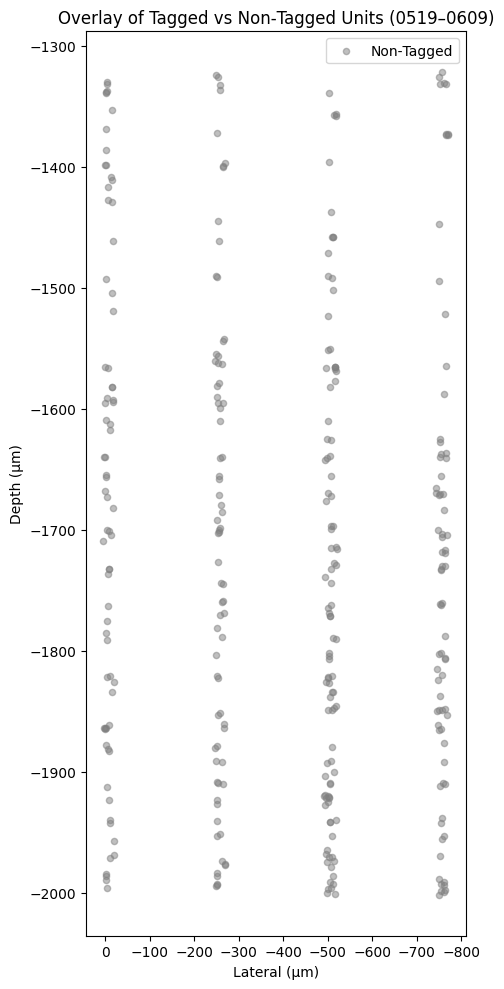

In [19]:
# ── 3) Plot overlay ───────────────────────────────────────────────────────
plt.figure(figsize=(5,10))
plt.scatter(all_non_xy[:,0], all_non_xy[:,1],
            s=20, color='gray', alpha=0.5, label='Non‑Tagged')
if len(all_tagged_xy)!=0:
    plt.scatter(all_tagged_xy[:,0], all_tagged_xy[:,1],
            s=20, color='red',  alpha=0.8, label='Tagged')
plt.gca().invert_xaxis()
plt.xlabel('Lateral (µm)')
plt.ylabel('Depth (µm)')
plt.title('Overlay of Tagged vs Non‑Tagged Units (0519–0609)')
plt.legend()
plt.tight_layout()
# plt.savefig(spike_dir+'/unit_position_map.png', dpi=300)
plt.show()

In [20]:
from scipy.stats import gaussian_kde
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans

core_dir = r"D:/Neuropixels"
date_strs = [
    '06162025'
]
session_names = [f"9303_{d}_tagging_g0" for d in date_strs]
sample_rate = 30000  # Hz, change as needed
peak_to_troughs = []
half_peak_widths = []
firing_rates = []
plotted_units = []
waveforms = []
cv_list = []

for session in session_names:
    ks_dir = os.path.join(core_dir, session, f"{session}_imec0", "kilosort4")
    # Load data
    amplitude_path = os.path.join(ks_dir, 'amplitudes.npy')
    amplitudes = np.load(amplitude_path)
    spike_times_path = os.path.join(ks_dir, 'spike_times.npy')
    spike_times = np.load(spike_times_path)
    spike_clusters_path = os.path.join(ks_dir, 'spike_clusters.npy')
    spike_clusters = np.load(spike_clusters_path)
    templates_path = os.path.join(ks_dir, 'templates.npy')
    templates = np.load(templates_path)  
    unit_label_path= os.path.join(ks_dir+"qMetrics", "templates._bc_unit_labels.tsv")
    unit_label = pd.read_csv(unit_label_path, sep='\t')
    units = unit_label[unit_label["unitType"].isin([1,2])].index
    # Plot amplitude distributions for each "Good" cluster
    for unit_idx in units:
        wf = templates[unit_idx, :, :]  # [n_timepoints, n_channels]
        min_vals = wf.min(axis=0)
        max_vals = wf.max(axis=0)
        abs_peaks = np.where(np.abs(min_vals) > np.abs(max_vals), min_vals, max_vals)
        main_ch_idx = np.argmax(np.abs(abs_peaks))
        main_peak_val = abs_peaks[main_ch_idx]
        waveform = wf[:, main_ch_idx]
        if main_peak_val > 0: # Skip if it's non-somatic
            continue

        # Peak-to-trough: find most negative point (peak) and next positive peak (trough) after that
        peak_idx = np.argmin(waveform)
        if peak_idx < len(waveform) - 1:
            trough_idx = peak_idx + np.argmax(waveform[peak_idx:])
        else:
            trough_idx = peak_idx
        peak_to_trough = (trough_idx - peak_idx) * 1000 / sample_rate  # ms

        # Half-peak width (width at half-minimum value)
        half_min = waveform[peak_idx] / 2
        # Find where waveform crosses half_min before and after the peak
        left_idx = np.where(waveform[:peak_idx] > half_min)[0]
        left_cross = left_idx[-1] if len(left_idx) > 0 else 0
        right_idx = np.where(waveform[peak_idx:] > half_min)[0]
        right_cross = peak_idx + right_idx[0] if len(right_idx) > 0 else len(waveform) - 1
        half_peak_width = (right_cross - left_cross) * 1000 / sample_rate  # ms

        # --- Firing rate ---
        # Firing rate = n_spikes / duration (sec)
        idx = np.where(spike_clusters == unit_idx)[0]
        n_spikes = len(idx)
        unit_spike_times = spike_times[idx]
        duration = (unit_spike_times.max() - unit_spike_times.min()) / sample_rate
        fr = n_spikes / duration if duration > 0 else 0

        # ISI cv
        isi = np.diff(unit_spike_times)
        cv = np.std(isi) / np.mean(isi)

        peak_to_troughs.append(peak_to_trough)
        half_peak_widths.append(half_peak_width)
        firing_rates.append(fr)
        plotted_units.append(unit_idx)
        waveforms.append(waveform)
        cv_list.append(cv)

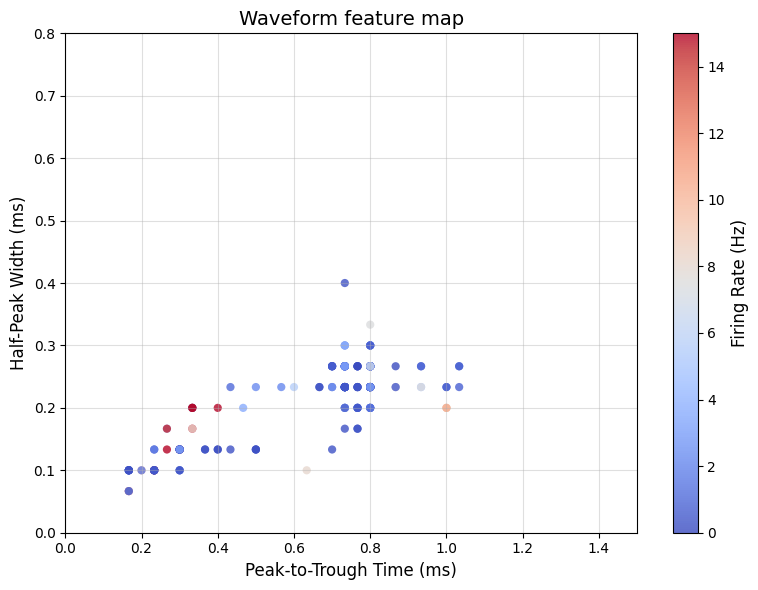

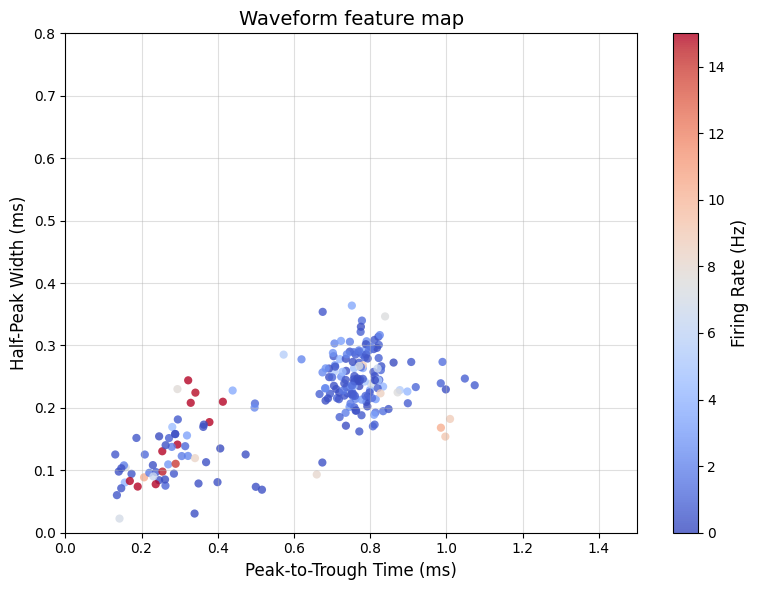

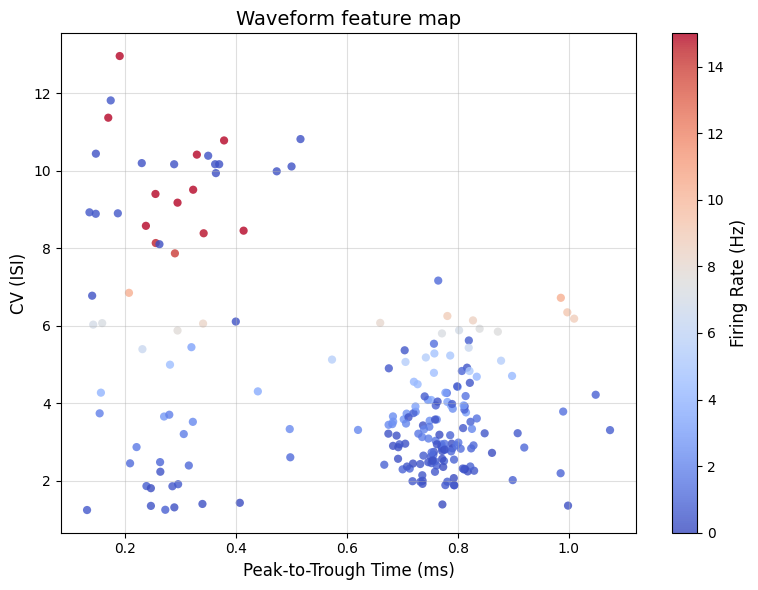

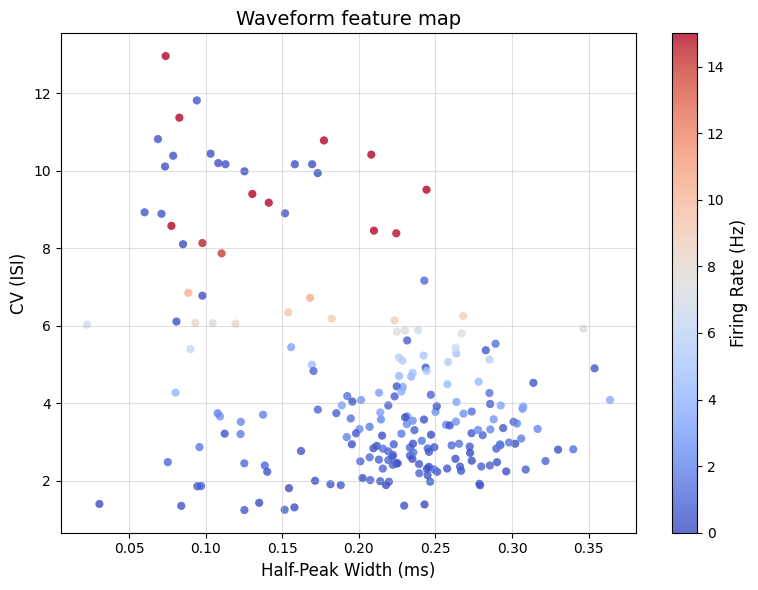

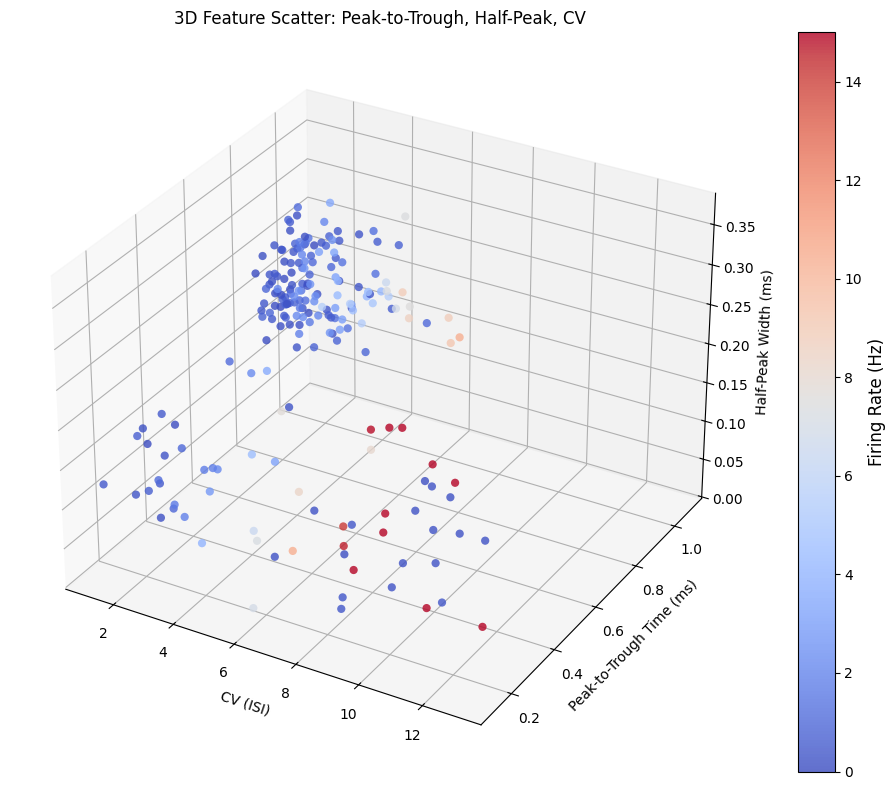

c:\Users\kouhi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


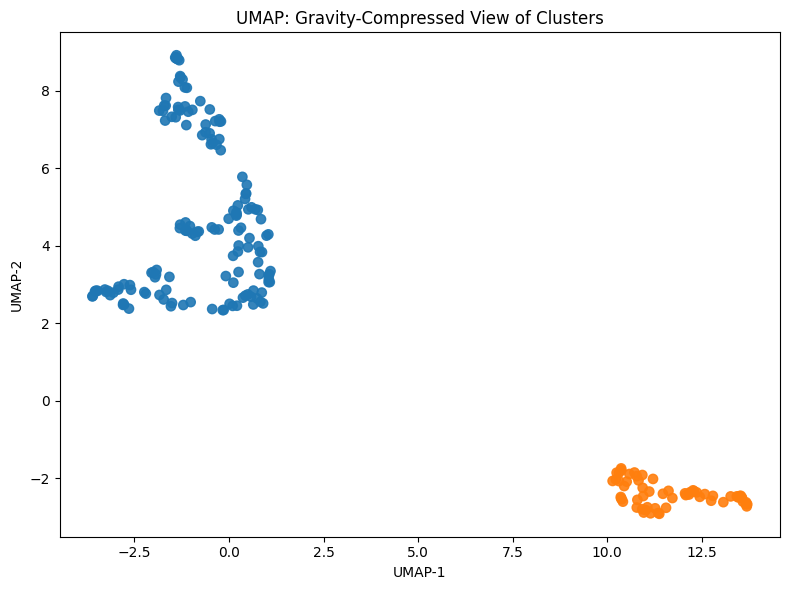

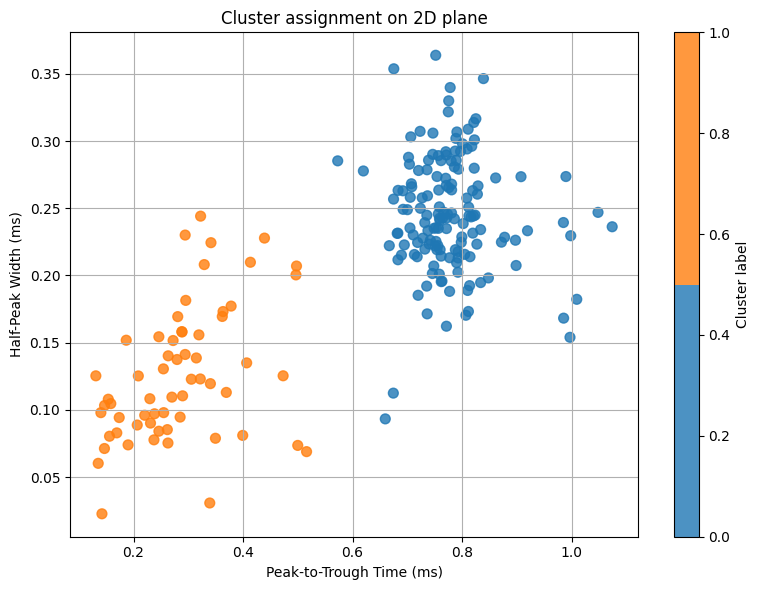

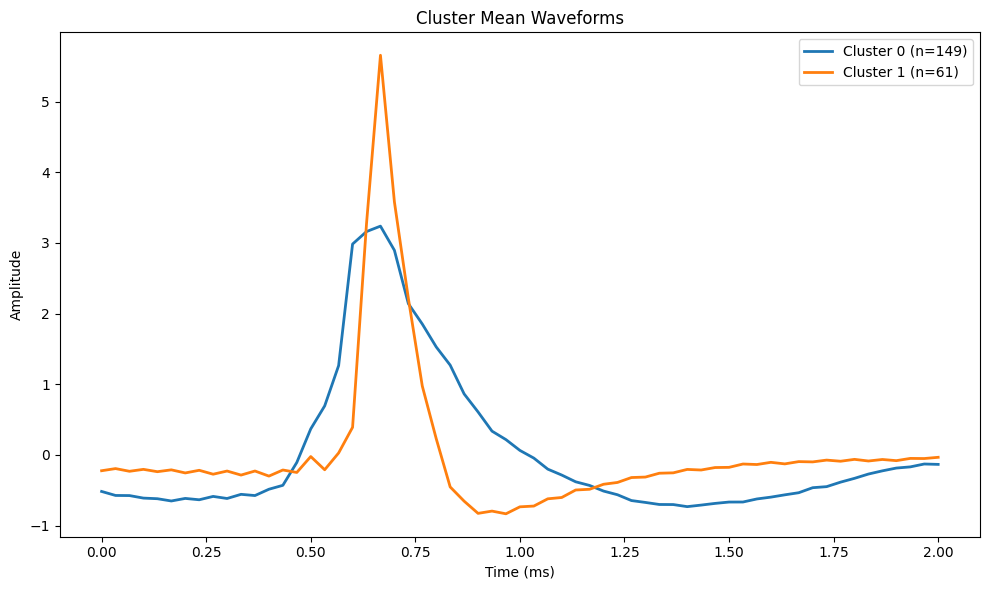

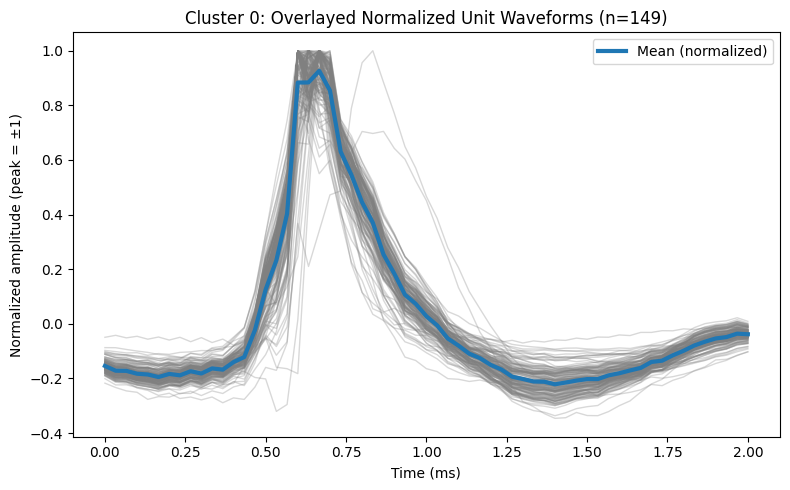

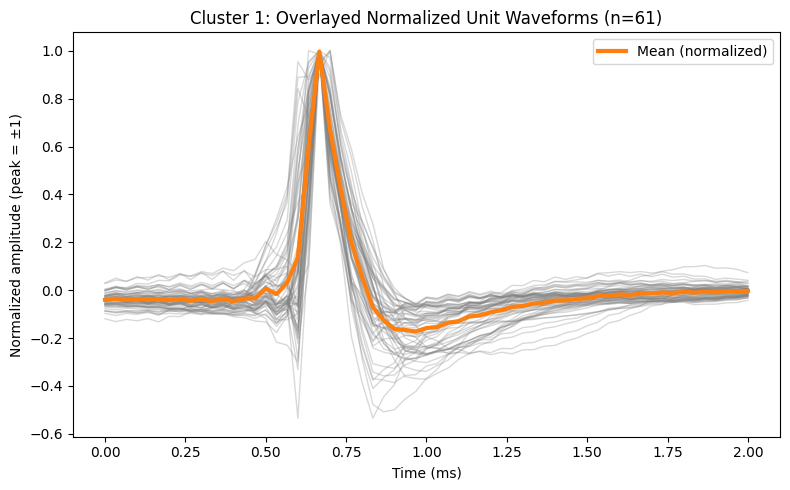

In [21]:
%matplotlib inline
# --- Plot ---
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    peak_to_troughs,
    half_peak_widths,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Peak-to-Trough Time (ms)", fontsize=12)
plt.ylabel("Half-Peak Width (ms)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.ylim(0, 0.8)
plt.xlim(0, 1.5)
plt.tight_layout()
plt.show()

# Add jitter to the scatter plot for better visibility
rng = np.random.default_rng(42)
jitter_strength = 0.03  # ms
x_jitter = peak_to_troughs + rng.normal(0, jitter_strength, len(peak_to_troughs))
y_jitter = half_peak_widths + rng.normal(0, jitter_strength, len(half_peak_widths))
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x_jitter,
    y_jitter,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Peak-to-Trough Time (ms)", fontsize=12)
plt.ylabel("Half-Peak Width (ms)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.ylim(0, 0.8)
plt.xlim(0, 1.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x_jitter,
    cv_list,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Peak-to-Trough Time (ms)", fontsize=12)
plt.ylabel("CV (ISI)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    y_jitter,
    cv_list,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Half-Peak Width (ms)", fontsize=12)
plt.ylabel("CV (ISI)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


# 3D scatter plot of features
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    cv_list,
    x_jitter,
    y_jitter,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
ax.set_ylabel('Peak-to-Trough Time (ms)')
ax.set_zlabel('Half-Peak Width (ms)')
ax.set_xlabel('CV (ISI)')
plt.title('3D Feature Scatter: Peak-to-Trough, Half-Peak, CV')
plt.tight_layout()
plt.show()


# UMAP clustering and visualization
import umap
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
features = np.column_stack([x_jitter, y_jitter])
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.01)
embedding = reducer.fit_transform(features)  # shape: (n_units, 2)
db = DBSCAN(eps=1.1, min_samples=5).fit(embedding)
cluster_labels = db.labels_
n_colors = np.max(cluster_labels) + 1
color_cmap = ListedColormap(plt.get_cmap('tab10').colors[:n_colors])
plt.figure(figsize=(8,6))
plt.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=cluster_labels, cmap=color_cmap, s=45, alpha=0.9
)
plt.title('UMAP: Gravity-Compressed View of Clusters')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.show()


# Plot clusters on the waveform feature plane
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x_jitter, y_jitter, c=cluster_labels, cmap=color_cmap, s=50, alpha=0.8
)
plt.xlabel("Peak-to-Trough Time (ms)")
plt.ylabel("Half-Peak Width (ms)")
plt.title("Cluster assignment on 2D plane")
plt.colorbar(sc, label="Cluster label")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean main channel waveform for each cluster
waveforms = np.array(waveforms)  # shape: (n_units, n_samples)
n_clusters = np.max(cluster_labels) + 1
colors = plt.get_cmap('tab10')
sample_rate = 30000  # or your actual value
time = np.arange(waveforms.shape[1]) * 1000 / sample_rate  # ms

# Mean waveform for each cluster (all on one plot) ---
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    idx = np.where(cluster_labels == i)[0]
    if len(idx) == 0:
        continue
    avg_wf = np.mean(waveforms[idx, :], axis=0)
    plt.plot(time, -avg_wf, color=colors(i), linewidth=2, label=f'Cluster {i} (n={len(idx)})')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Cluster Mean Waveforms')
plt.legend()
plt.tight_layout()
plt.show()

# Each cluster: overlay all unit waveforms + mean ---
for i in range(n_clusters):
    idx = np.where(cluster_labels == i)[0]
    if len(idx) == 0:
        continue

    norm_waveforms = []
    for j in idx:
        wf = waveforms[j]
        peak_idx = np.argmax(np.abs(wf))  # index of largest magnitude
        peak_val = wf[peak_idx]
        norm_waveforms.append(wf / np.abs(peak_val))
    norm_waveforms = np.stack(norm_waveforms)
    avg_norm_wf = np.mean(norm_waveforms, axis=0)
    plt.figure(figsize=(8, 5))
    for nwf in norm_waveforms:
        plt.plot(time, -nwf, color='gray', alpha=0.3, linewidth=1)
    plt.plot(time, -avg_norm_wf, color=colors(i), linewidth=3, label='Mean (normalized)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Normalized amplitude (peak = ±1)')
    plt.title(f'Cluster {i}: Overlayed Normalized Unit Waveforms (n={len(idx)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [180]:
core_dir = r"D:/Neuropixels"
date_strs = [
    '01282025', '01292025', '01302025', '01312025', '02012025',
    '02022025', '02032025', '02042025', '02062025', '02072025',
    '02092025', '02102025', '02112025', '02122025', '02132025',
    '02142025', '02152025', '02162025'
]
session_names = [f"9153_{d}_tagging_g0" for d in date_strs]
sample_rate = 30000  # Hz, change as needed
peak_to_troughs = []
half_peak_widths = []
firing_rates = []
plotted_units = []
waveforms = []
cv_list = []

for session in session_names:
    ks_dir = os.path.join(core_dir, session, f"{session}_imec0", "kilosort4")
    # Load data
    amplitude_path = os.path.join(ks_dir, 'amplitudes.npy')
    amplitudes = np.load(amplitude_path)
    spike_times_path = os.path.join(ks_dir, 'spike_times.npy')
    spike_times = np.load(spike_times_path)
    spike_clusters_path = os.path.join(ks_dir, 'spike_clusters.npy')
    spike_clusters = np.load(spike_clusters_path)
    templates_path = os.path.join(ks_dir, 'templates.npy')
    templates = np.load(templates_path)  
    unit_label_path= os.path.join(ks_dir+"qMetrics", "templates._bc_unit_labels.tsv")
    unit_label = pd.read_csv(unit_label_path, sep='\t')
    units = unit_label[unit_label["unitType"].isin([1,2])].index
    # Plot amplitude distributions for each "Good" cluster
    for unit_idx in units:
        wf = templates[unit_idx, :, :]  # [n_timepoints, n_channels]
        min_vals = wf.min(axis=0)
        max_vals = wf.max(axis=0)
        abs_peaks = np.where(np.abs(min_vals) > np.abs(max_vals), min_vals, max_vals)
        main_ch_idx = np.argmax(np.abs(abs_peaks))
        main_peak_val = abs_peaks[main_ch_idx]
        waveform = wf[:, main_ch_idx]
        if main_peak_val > 0: # Skip if it's non-somatic
            continue

        # Peak-to-trough: find most negative point (peak) and next positive peak (trough) after that
        peak_idx = np.argmin(waveform)
        if peak_idx < len(waveform) - 1:
            trough_idx = peak_idx + np.argmax(waveform[peak_idx:])
        else:
            trough_idx = peak_idx
        peak_to_trough = (trough_idx - peak_idx) * 1000 / sample_rate  # ms

        # Half-peak width (width at half-minimum value)
        half_min = waveform[peak_idx] / 2
        # Find where waveform crosses half_min before and after the peak
        left_idx = np.where(waveform[:peak_idx] > half_min)[0]
        left_cross = left_idx[-1] if len(left_idx) > 0 else 0
        right_idx = np.where(waveform[peak_idx:] > half_min)[0]
        right_cross = peak_idx + right_idx[0] if len(right_idx) > 0 else len(waveform) - 1
        half_peak_width = (right_cross - left_cross) * 1000 / sample_rate  # ms

        # --- Firing rate ---
        # Firing rate = n_spikes / duration (sec)
        idx = np.where(spike_clusters == unit_idx)[0]
        n_spikes = len(idx)
        unit_spike_times = spike_times[idx]
        duration = (unit_spike_times.max() - unit_spike_times.min()) / sample_rate
        fr = n_spikes / duration if duration > 0 else 0

        # ISI cv
        isi = np.diff(unit_spike_times)
        cv = np.std(isi) / np.mean(isi)

        peak_to_troughs.append(peak_to_trough)
        half_peak_widths.append(half_peak_width)
        firing_rates.append(fr)
        plotted_units.append(unit_idx)
        waveforms.append(waveform)
        cv_list.append(cv)

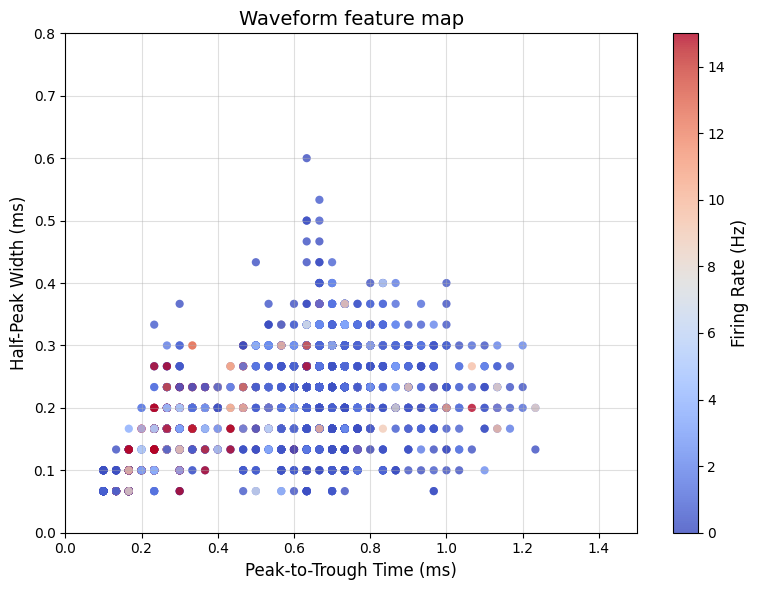

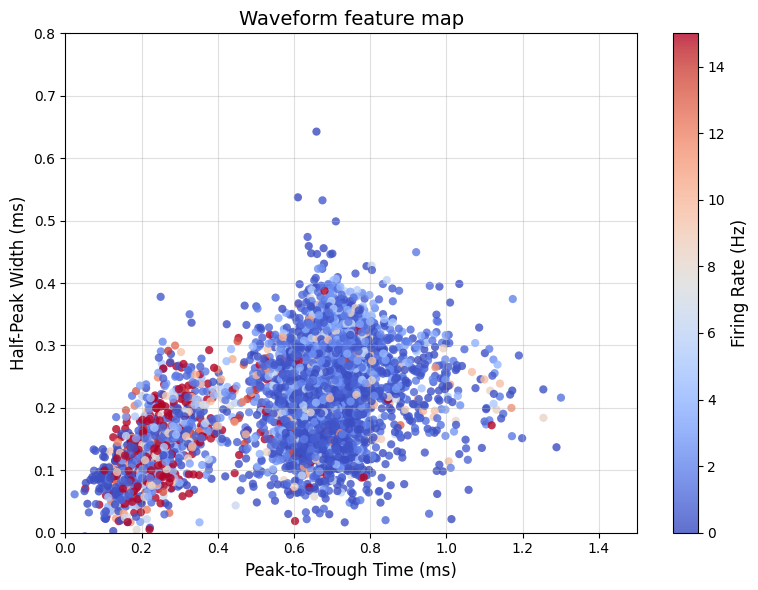

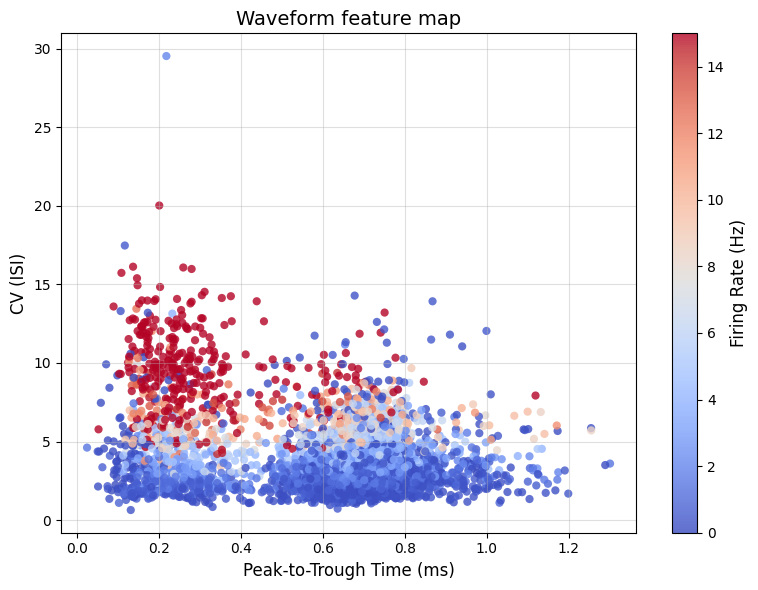

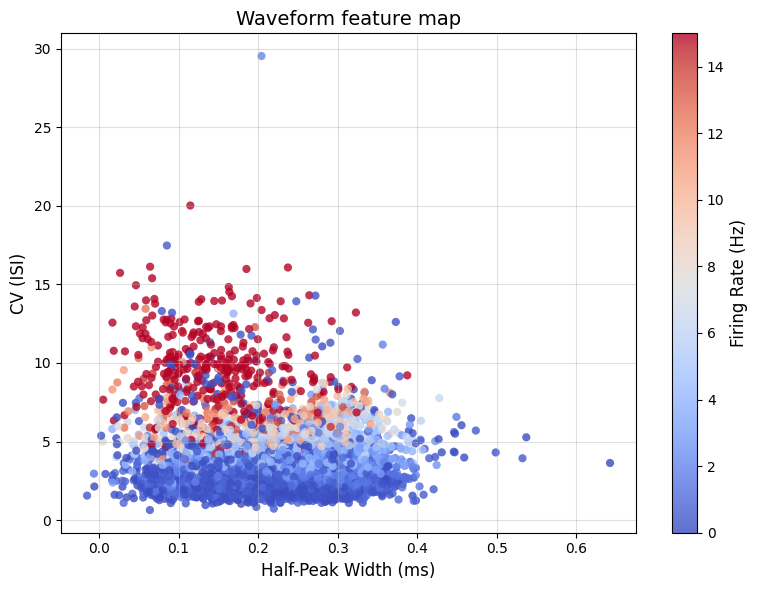

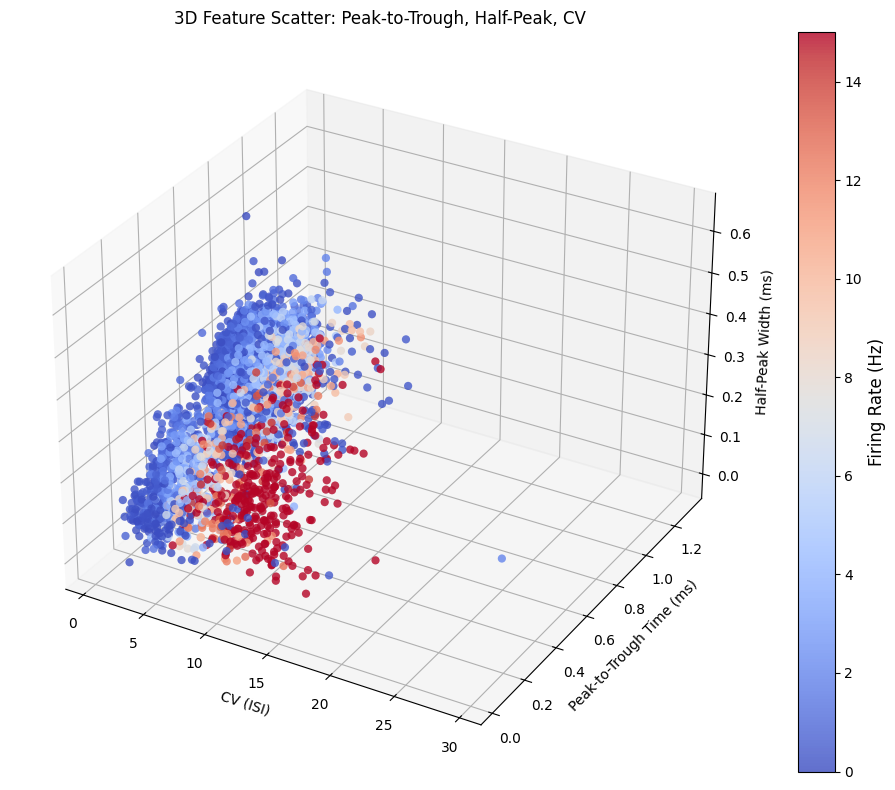

c:\Users\kouhi\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


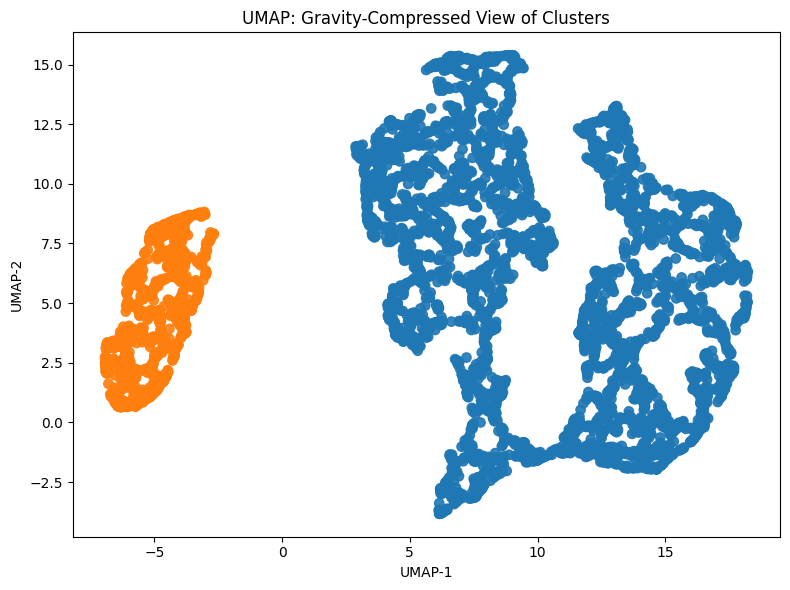

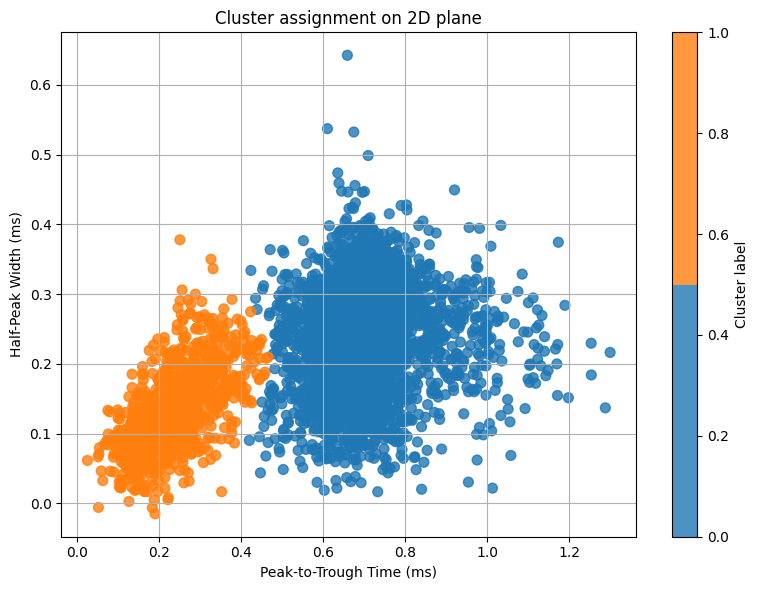

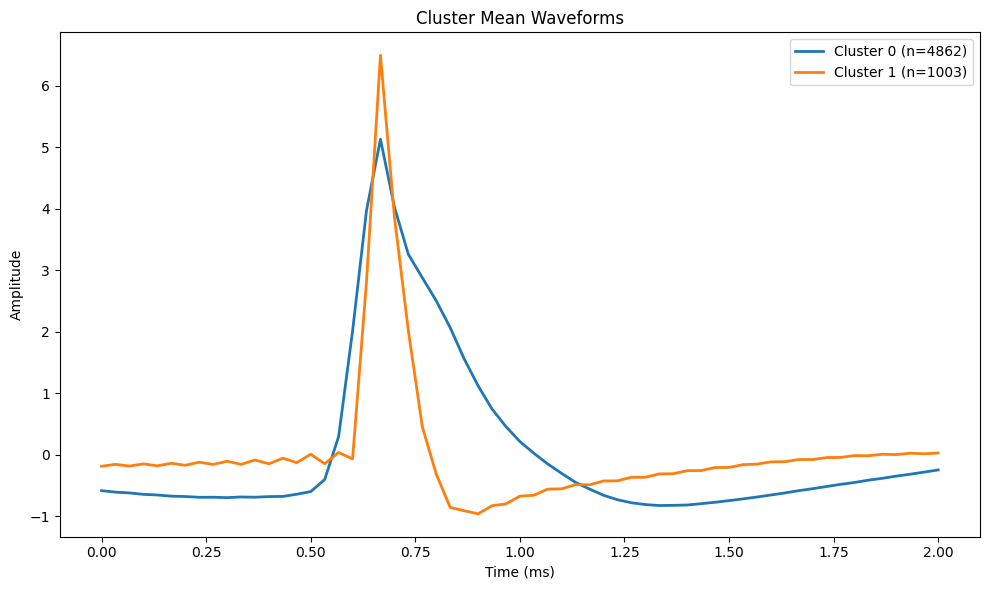

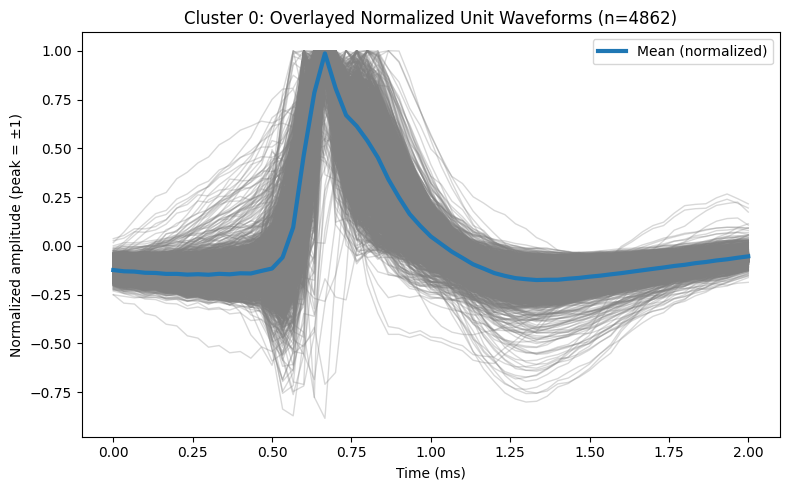

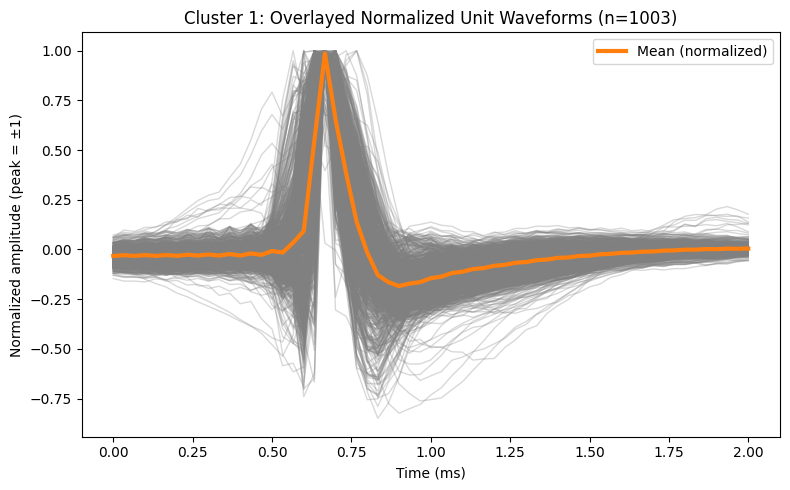

In [184]:
%matplotlib inline
# --- Plot ---
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    peak_to_troughs,
    half_peak_widths,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Peak-to-Trough Time (ms)", fontsize=12)
plt.ylabel("Half-Peak Width (ms)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.ylim(0, 0.8)
plt.xlim(0, 1.5)
plt.tight_layout()
plt.show()

# Add jitter to the scatter plot for better visibility
rng = np.random.default_rng(42)
jitter_strength = 0.03  # ms
x_jitter = peak_to_troughs + rng.normal(0, jitter_strength, len(peak_to_troughs))
y_jitter = half_peak_widths + rng.normal(0, jitter_strength, len(half_peak_widths))
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x_jitter,
    y_jitter,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Peak-to-Trough Time (ms)", fontsize=12)
plt.ylabel("Half-Peak Width (ms)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.ylim(0, 0.8)
plt.xlim(0, 1.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x_jitter,
    cv_list,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Peak-to-Trough Time (ms)", fontsize=12)
plt.ylabel("CV (ISI)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    y_jitter,
    cv_list,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
plt.xlabel("Half-Peak Width (ms)", fontsize=12)
plt.ylabel("CV (ISI)", fontsize=12)
plt.title(f"Waveform feature map", fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


# 3D scatter plot of features
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    cv_list,
    x_jitter,
    y_jitter,
    c=firing_rates,
    cmap='coolwarm',
    s=35,
    alpha=0.8,
    edgecolor='none',
    vmin=0,
    vmax=15
)
cbar = plt.colorbar(sc)
cbar.set_label('Firing Rate (Hz)', fontsize=12)
ax.set_ylabel('Peak-to-Trough Time (ms)')
ax.set_zlabel('Half-Peak Width (ms)')
ax.set_xlabel('CV (ISI)')
plt.title('3D Feature Scatter: Peak-to-Trough, Half-Peak, CV')
plt.tight_layout()
plt.show()


# UMAP clustering and visualization
import umap
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
features = np.column_stack([x_jitter, y_jitter])
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.1)
embedding = reducer.fit_transform(features)  # shape: (n_units, 2)
db = DBSCAN(eps=1.1, min_samples=5).fit(embedding)
cluster_labels = db.labels_
n_colors = np.max(cluster_labels) + 1
color_cmap = ListedColormap(plt.get_cmap('tab10').colors[:n_colors])
plt.figure(figsize=(8,6))
plt.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=cluster_labels, cmap=color_cmap, s=45, alpha=0.9
)
plt.title('UMAP: Gravity-Compressed View of Clusters')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.show()


# Plot clusters on the waveform feature plane
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x_jitter, y_jitter, c=cluster_labels, cmap=color_cmap, s=50, alpha=0.8
)
plt.xlabel("Peak-to-Trough Time (ms)")
plt.ylabel("Half-Peak Width (ms)")
plt.title("Cluster assignment on 2D plane")
plt.colorbar(sc, label="Cluster label")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean main channel waveform for each cluster
waveforms = np.array(waveforms)  # shape: (n_units, n_samples)
n_clusters = np.max(cluster_labels) + 1
colors = plt.get_cmap('tab10')
sample_rate = 30000  # or your actual value
time = np.arange(waveforms.shape[1]) * 1000 / sample_rate  # ms

# Mean waveform for each cluster (all on one plot) ---
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    idx = np.where(cluster_labels == i)[0]
    if len(idx) == 0:
        continue
    avg_wf = np.mean(waveforms[idx, :], axis=0)
    plt.plot(time, -avg_wf, color=colors(i), linewidth=2, label=f'Cluster {i} (n={len(idx)})')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Cluster Mean Waveforms')
plt.legend()
plt.tight_layout()
plt.show()

# Each cluster: overlay all unit waveforms + mean ---
for i in range(n_clusters):
    idx = np.where(cluster_labels == i)[0]
    if len(idx) == 0:
        continue

    norm_waveforms = []
    for j in idx:
        wf = waveforms[j]
        peak_idx = np.argmax(np.abs(wf))  # index of largest magnitude
        peak_val = wf[peak_idx]
        norm_waveforms.append(wf / np.abs(peak_val))
    norm_waveforms = np.stack(norm_waveforms)
    avg_norm_wf = np.mean(norm_waveforms, axis=0)
    plt.figure(figsize=(8, 5))
    for nwf in norm_waveforms:
        plt.plot(time, -nwf, color='gray', alpha=0.3, linewidth=1)
    plt.plot(time, -avg_norm_wf, color=colors(i), linewidth=3, label='Mean (normalized)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Normalized amplitude (peak = ±1)')
    plt.title(f'Cluster {i}: Overlayed Normalized Unit Waveforms (n={len(idx)})')
    plt.legend()
    plt.tight_layout()
    plt.show()